# Table of contents
This jupyter notebook is concerned with training a LSTM on our merged dataset


* [Normalization](#norm)
* [COVID Cases prediction](#covid)
* [Carbon dioxide prediction](#carbon)
* [Prediction for non existent country](#diy)


In [1]:
import numpy as np
import pandas as pd
from numpy import array
from numpy import hstack
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
import time

<h1> Only thing left to do </h1>
supply the path to the data file we supplied!

In [3]:
cases = pd.read_csv('/home/user/Documents/#master/Sem_2/AppliedMachineIntelligence/git/group19/data/merged_data/FINALLYmerged_data.csv')
cases.head()

Unnamed: 0  Unnamed: 0_x Country_x ISO_Code    Date_x  C1_School closing  \
0           0          1768   Austria      AUT  20200101                0.0   
1           1          1768   Austria      AUT  20200101                0.0   
2           2          1769   Austria      AUT  20200102                0.0   
3           3          1769   Austria      AUT  20200102                0.0   
4           4          1770   Austria      AUT  20200103                0.0   

   C2_Workplace closing  C3_Cancel public events  \
0                   0.0                      0.0   
1                   0.0                      0.0   
2                   0.0                      0.0   
3                   0.0                      0.0   
4                   0.0                      0.0   

   C4_Restrictions on gatherings  C5_Close public transport  ...  PUB_CO2_LOW  \
0                            0.0                        0.0  ...          0.0   
1                            0.0                        0.0  ...          0.0   
2                            0.0                        0.0  ...          0.0   
3                            0.0                        0.0  ...          0.0   
4                            0.0                        0.0  ...          0.0   

   RES_CO2_LOW  AVI_CO2_LOW  TOTAL_CO2_HIGH  PWR_CO2_HIGH  IND_CO2_HIGH  \
0          0.0          0.0             0.0           0.0           0.0   
1          0.0          0.0             0.0           0.0           0.0   
2          0.0          0.0             0.0           0.0           0.0   
3          0.0          0.0             0.0           0.0           0.0   
4          0.0          0.0             0.0           0.0           0.0   

   TRS_CO2_HIGH  PUB_CO2_HIGH  RES_CO2_HIGH  AVI_CO2_HIGH  
0           0.0           0.0           0.0           0.0  
1           0.0           0.0           0.0           0.0  
2           0.0           0.0           0.0           0.0  
3           0.0           0.0           0.0           0.0  
4           0.0           0.0           0.0           0.0  

[5 rows x 155 columns]

In [2]:
# split a multivariate sequence into samples
def split_sequences(sequences, n_steps):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the dataset
        if end_ix > len(sequences):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1, -1]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

<a class="anchor" id="norm"></a>
<h1>Normalization</h1> 

We need to notmalize all columns to [0-1], otherwise large numbers like the population will give the LSTM a hard time predicting small values. Or prediction targets, as well as the "DAY" (of the Year) variable will not be Normalized. Afterall, what would a normalized prediction mean? Furthermore columns which contain any amount of NaNs are dropped. 

Print all remaining Features


In [5]:
for col in list(cases):
    length = len(cases)
    cases[col].isnull().sum()
    print("NaNs in " + col + ": " + str((cases[col].isnull().sum()/length)*100) +"%" )

    if not (col == 'TOTAL_CO2_MED' or col == 'new_cases_per_million_y' or col == 'DAY'):
        #norm all
        if type(cases[col][140]) is not type(''):
            print(type(cases[col][140]))
            cases[col]=(cases[col]-cases[col].min())/(cases[col].max()-cases[col].min())
            print('Nomalized')

        if int((cases[col].isnull().sum()/length)*100) > 0:
            cases =cases.drop(col,axis=1)
    else:
        print('Not normalized, not dropped')
    
country = cases[cases['Country']=='Germany']
for i in range(country.shape[1]):
    print(i, country.columns[i])

NaNs in Unnamed: 0: 0.0%
<class 'numpy.int64'>
Nomalized
NaNs in Unnamed: 0_x: 0.0%
<class 'numpy.int64'>
Nomalized
NaNs in Country_x: 0.0%
NaNs in ISO_Code: 0.0%
NaNs in Date_x: 0.0%
<class 'numpy.int64'>
Nomalized
NaNs in C1_School closing: 0.0%
<class 'numpy.float64'>
Nomalized
NaNs in C2_Workplace closing: 0.0%
<class 'numpy.float64'>
Nomalized
NaNs in C3_Cancel public events: 0.0%
<class 'numpy.float64'>
Nomalized
NaNs in C4_Restrictions on gatherings: 0.0%
<class 'numpy.float64'>
Nomalized
NaNs in C5_Close public transport: 0.0%
<class 'numpy.float64'>
Nomalized
NaNs in C6_Stay at home requirements: 0.0%
<class 'numpy.float64'>
Nomalized
NaNs in C7_Restrictions on internal movement: 0.0%
<class 'numpy.float64'>
Nomalized
NaNs in C8_International travel controls: 0.0%
<class 'numpy.float64'>
Nomalized
NaNs in E1_Income support: 0.0%
<class 'numpy.float64'>
Nomalized
NaNs in E2_Debt/contract relief: 0.0%
<class 'numpy.float64'>
Nomalized
NaNs in E3_Fiscal measures: 0.0%
<class 'num

<a class="anchor" id="covid"></a>
<h1>COVID Cases prediction</h1> 

* Do test/train split
* define some parameters for hyperparam optimization
    - turn on/off plots
* Train the model
* Do Prediction on Testset

Using the foloowing Features to learn:
C1_School closing
C2_Workplace closing
C3_Cancel public events
C4_Restrictions on gatherings
C5_Close public transport
C6_Stay at home requirements
C7_Restrictions on internal movement
C8_International travel controls
E1_Income support
E2_Debt/contract relief
E3_Fiscal measures
E4_International support
H1_Public information campaigns
H2_Testing policy
H3_Contact tracing
H4_Emergency investment in healthcare
H5_Investment in vaccines
StringencyIndex
GovernmentResponseIndex
ContainmentHealthIndex
EconomicSupportIndex
DAY
year_week
Additional health/documents requirements upon arrival
Amendments to funeral and burial regulations
Awareness campaigns
Border checks 
Border closure 
Changes in prison-related policies
Checkpoints within the country
Closure of businesses and public services
Curfews
Domestic travel restrictions
Economic measures
Emergency administrative structures activated or established
Full lockdown
General recommendations
Health screeni

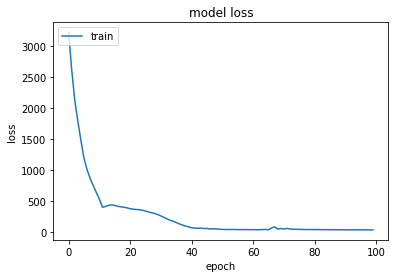

Training on:  Belgium
dict_keys(['loss'])


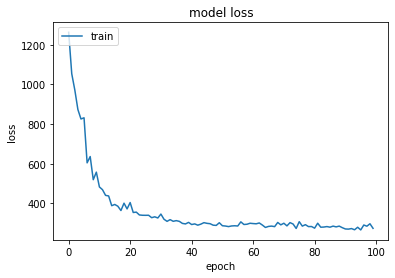

Training on:  Colombia
dict_keys(['loss'])


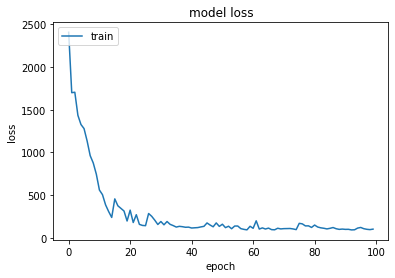

Training on:  Czech Republic
dict_keys(['loss'])


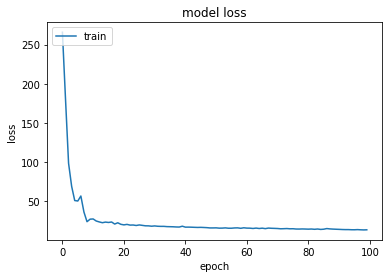

Training on:  Germany
dict_keys(['loss'])


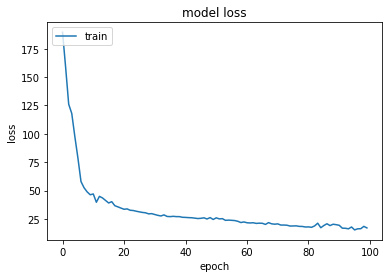

Training on:  Denmark
dict_keys(['loss'])


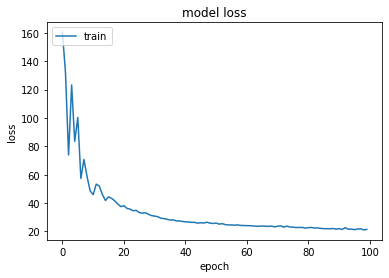

Training on:  Spain
dict_keys(['loss'])


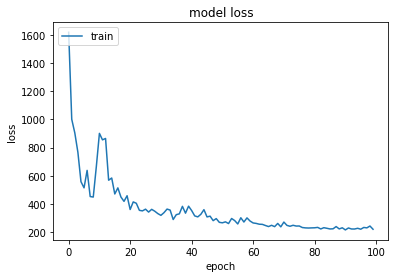

Training on:  Estonia
dict_keys(['loss'])


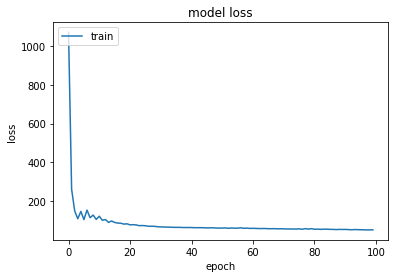

Training on:  Finland
dict_keys(['loss'])


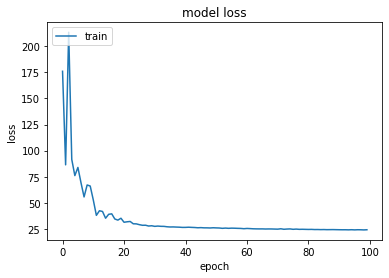

Training on:  France
dict_keys(['loss'])


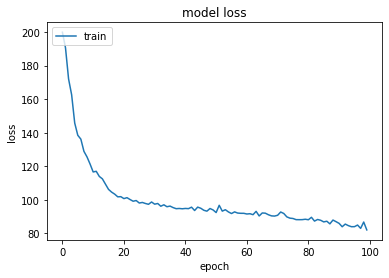

Training on:  United Kingdom
dict_keys(['loss'])


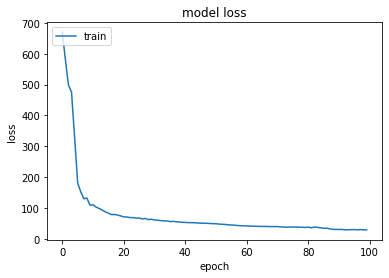

Training on:  Greece
dict_keys(['loss'])


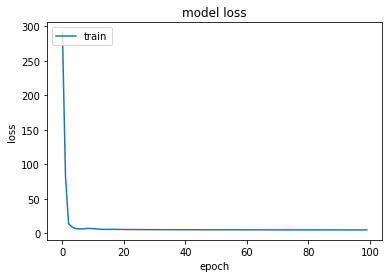

Training on:  Hungary
dict_keys(['loss'])


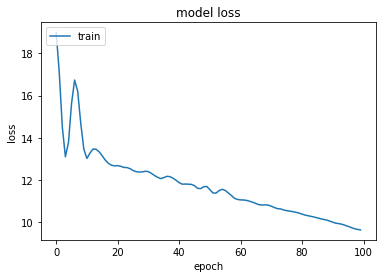

Training on:  Italy
dict_keys(['loss'])


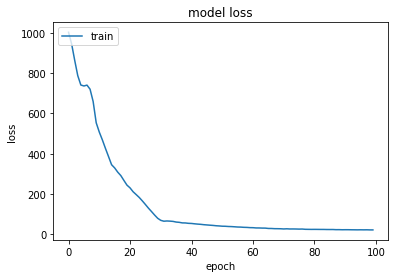

Training on:  Lithuania
dict_keys(['loss'])


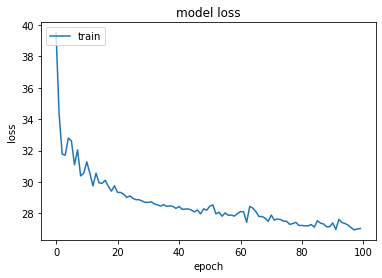

**Training Completed, elapsed time: 13.793495893478394 **
**Testing Started**
Testing on:  Luxembourg
Testing on:  Latvia
Testing on:  Netherlands
Testing on:  Norway
Testing on:  Portugal
Testing on:  Slovakia
Testing on:  Sweden
NEW BEST!!!
**Testing Completed**
**Average Error: 1956.9816


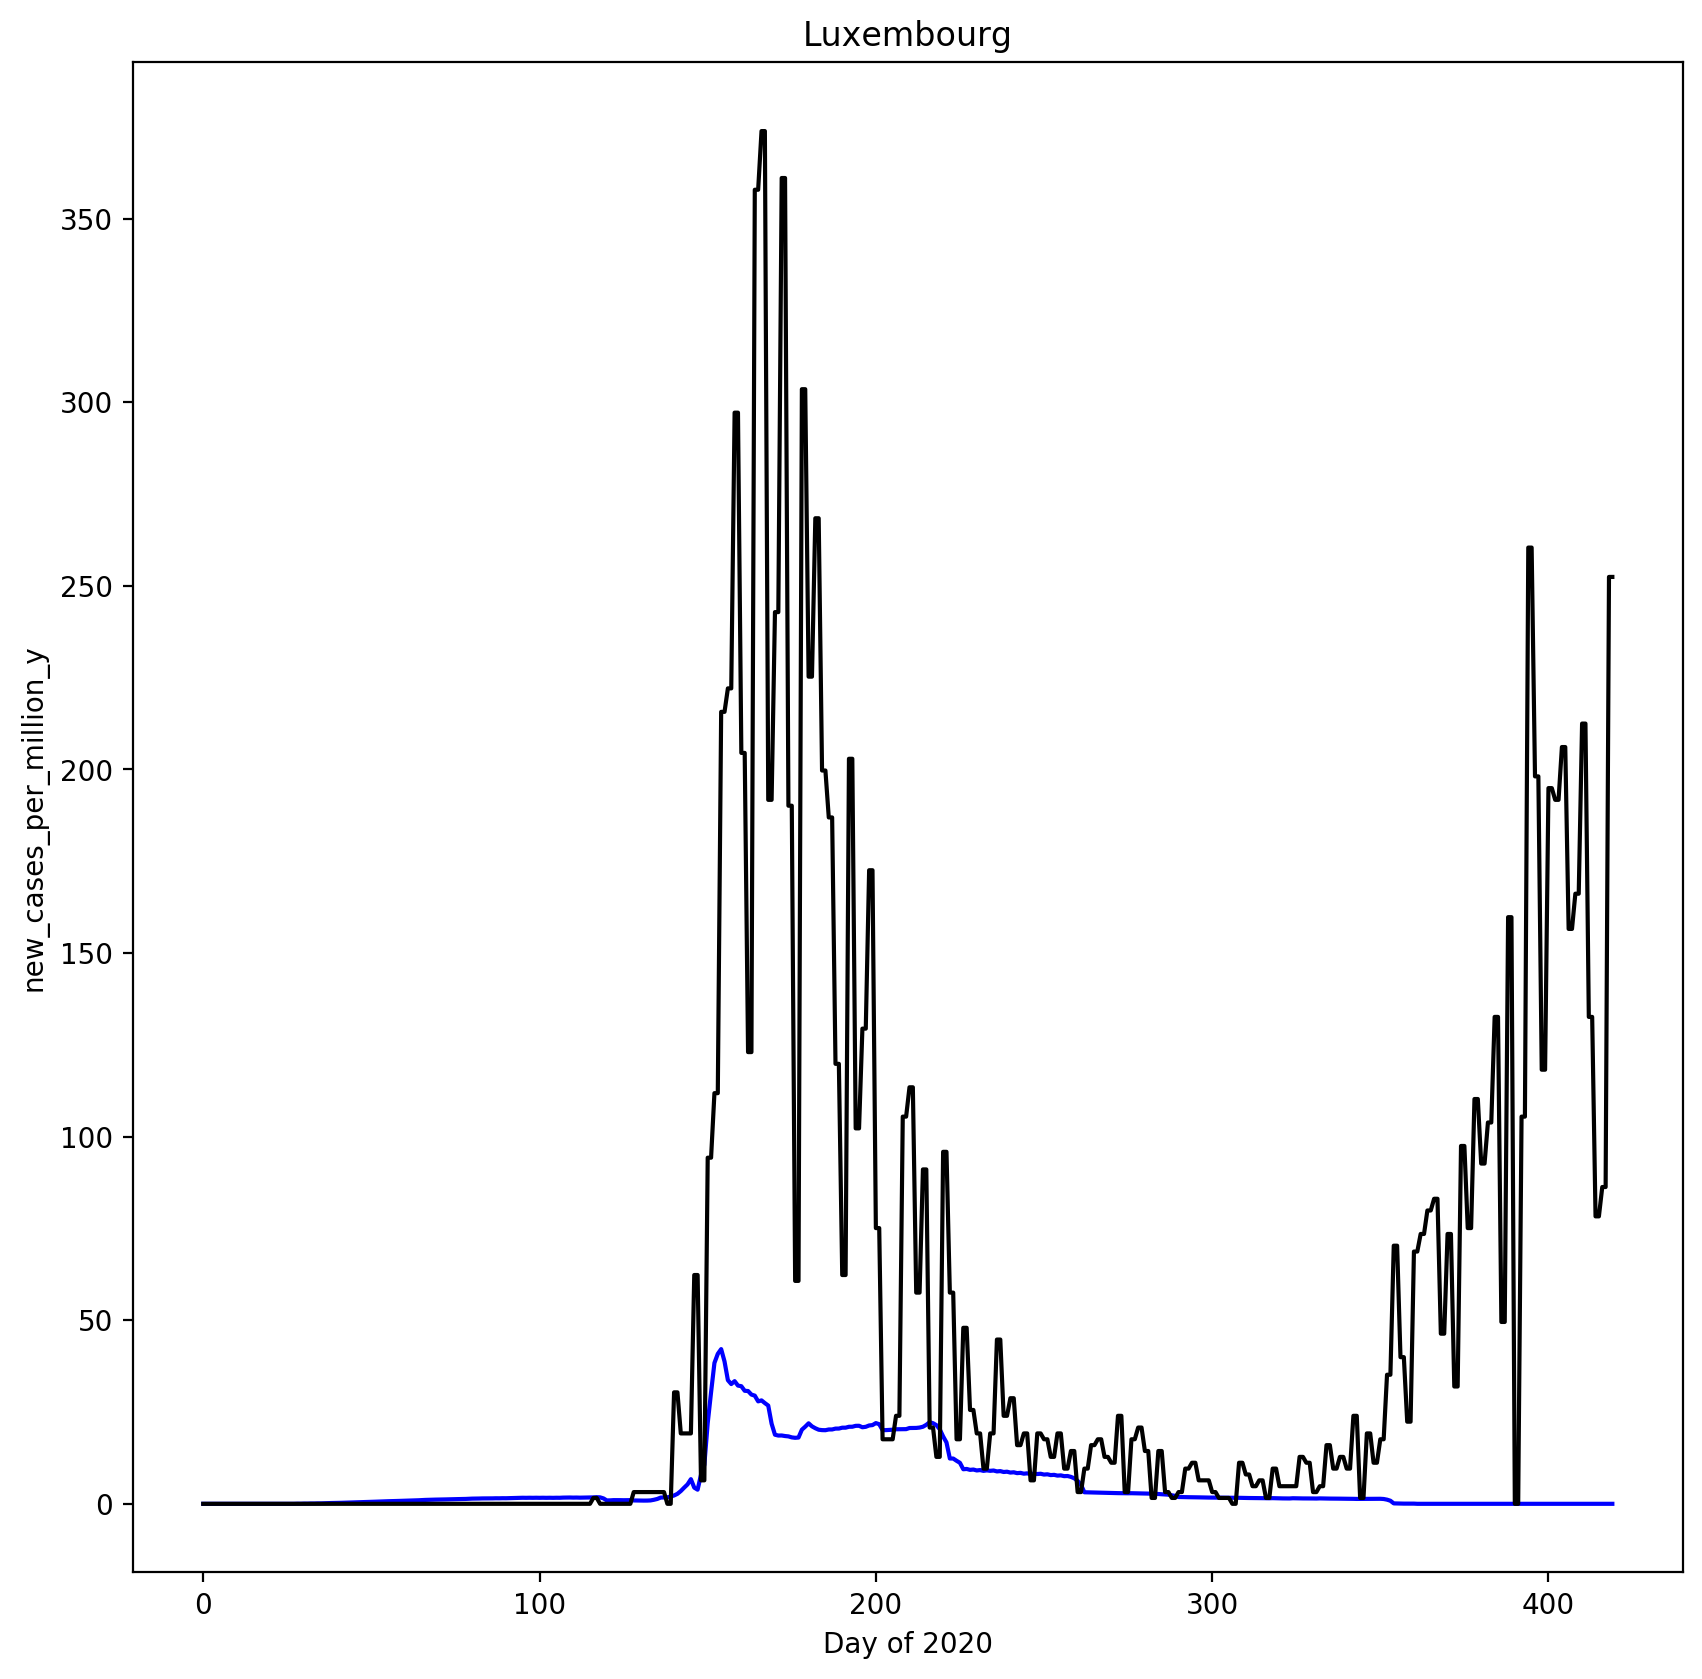

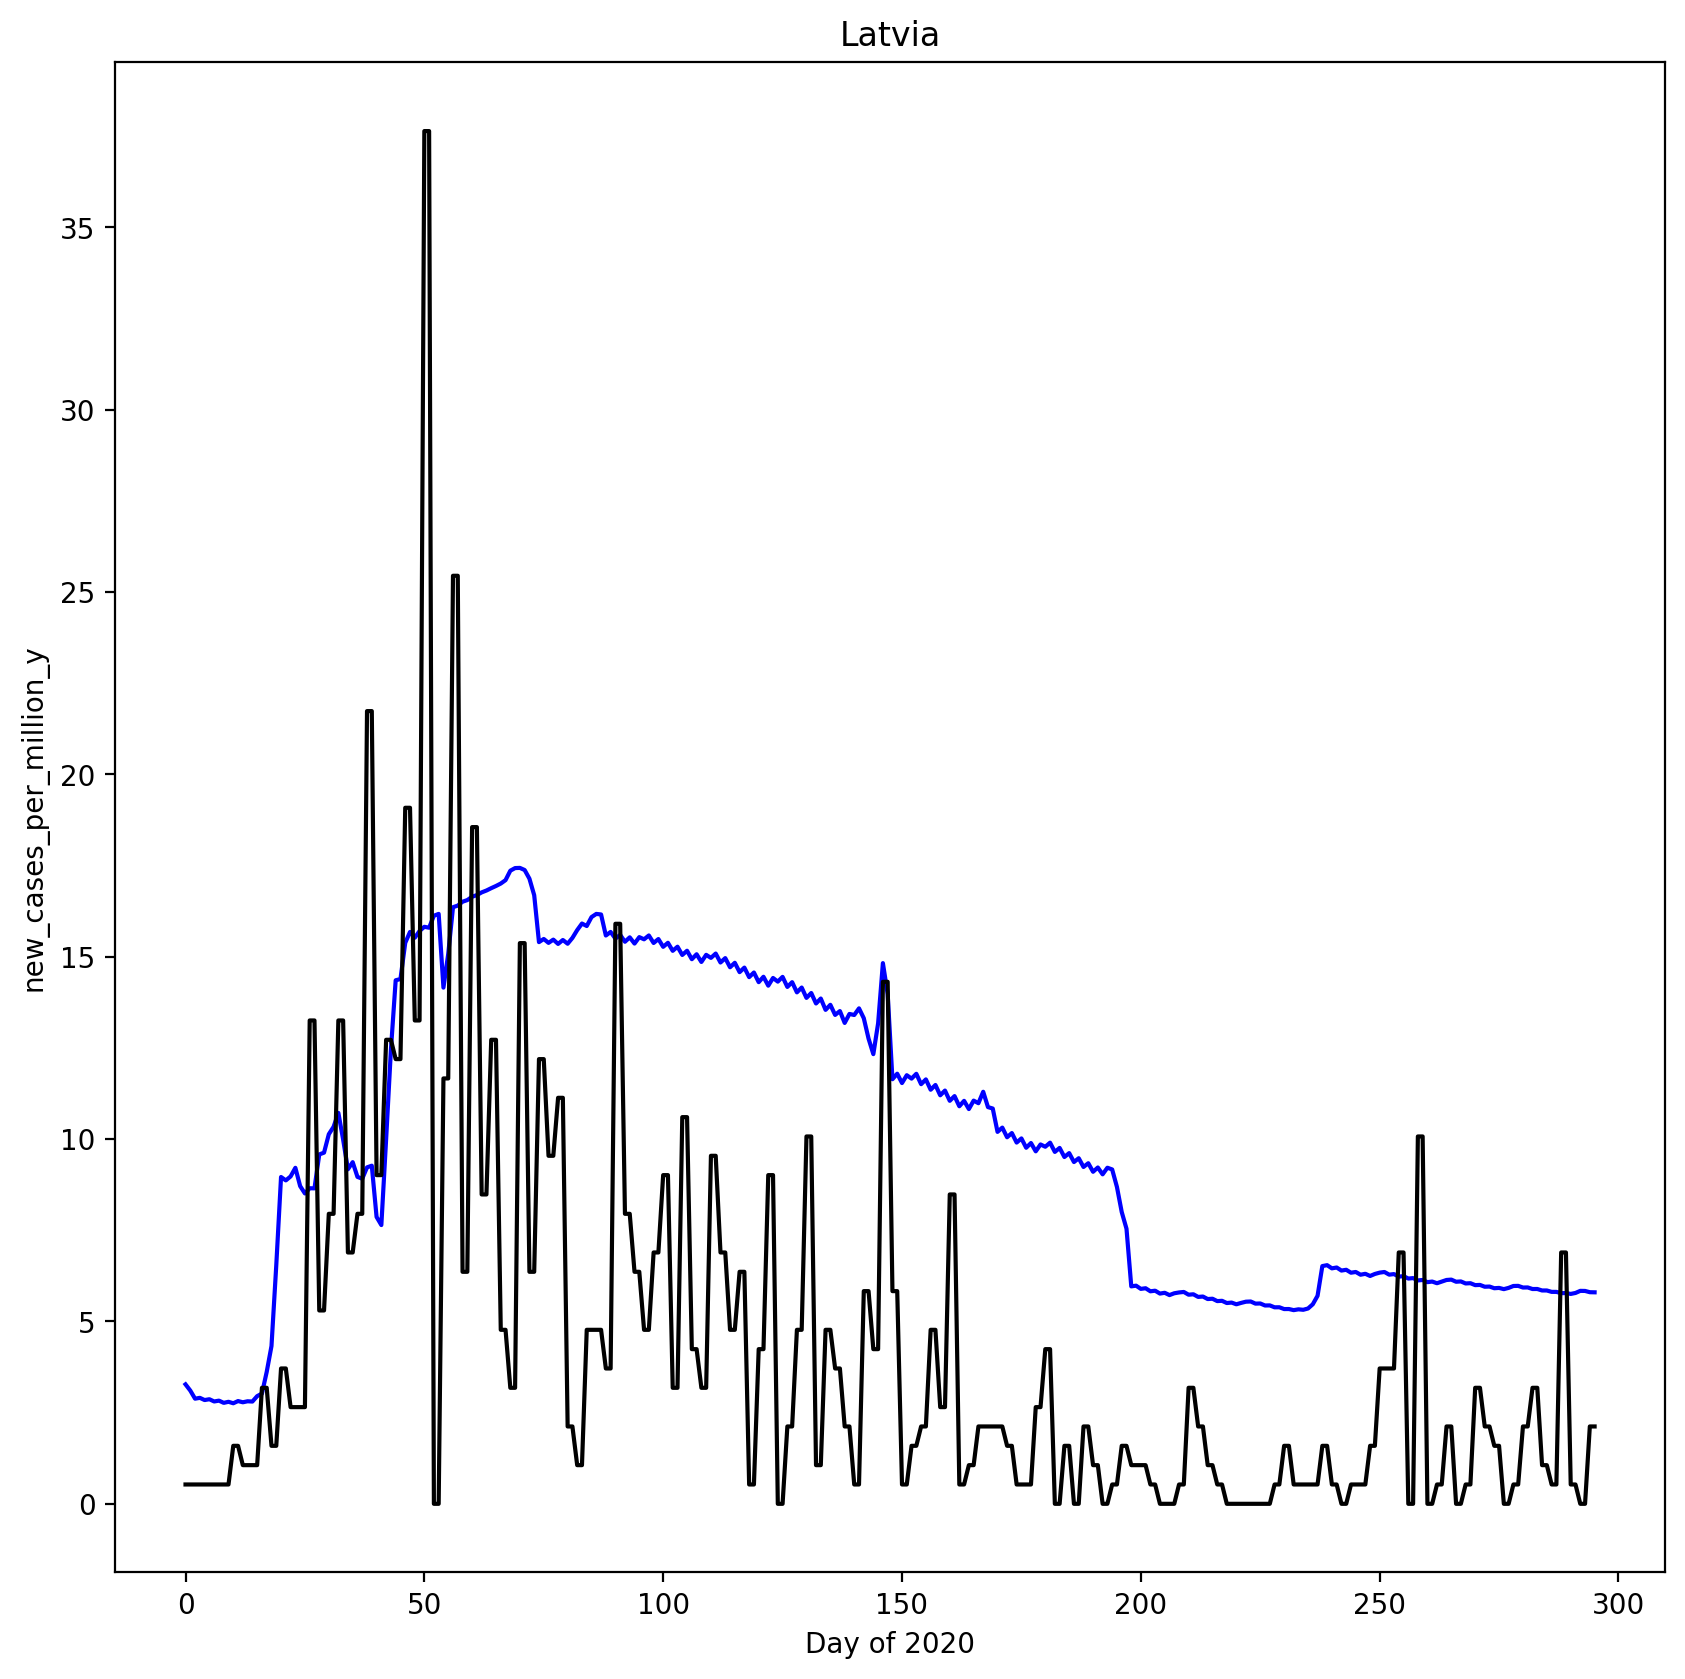

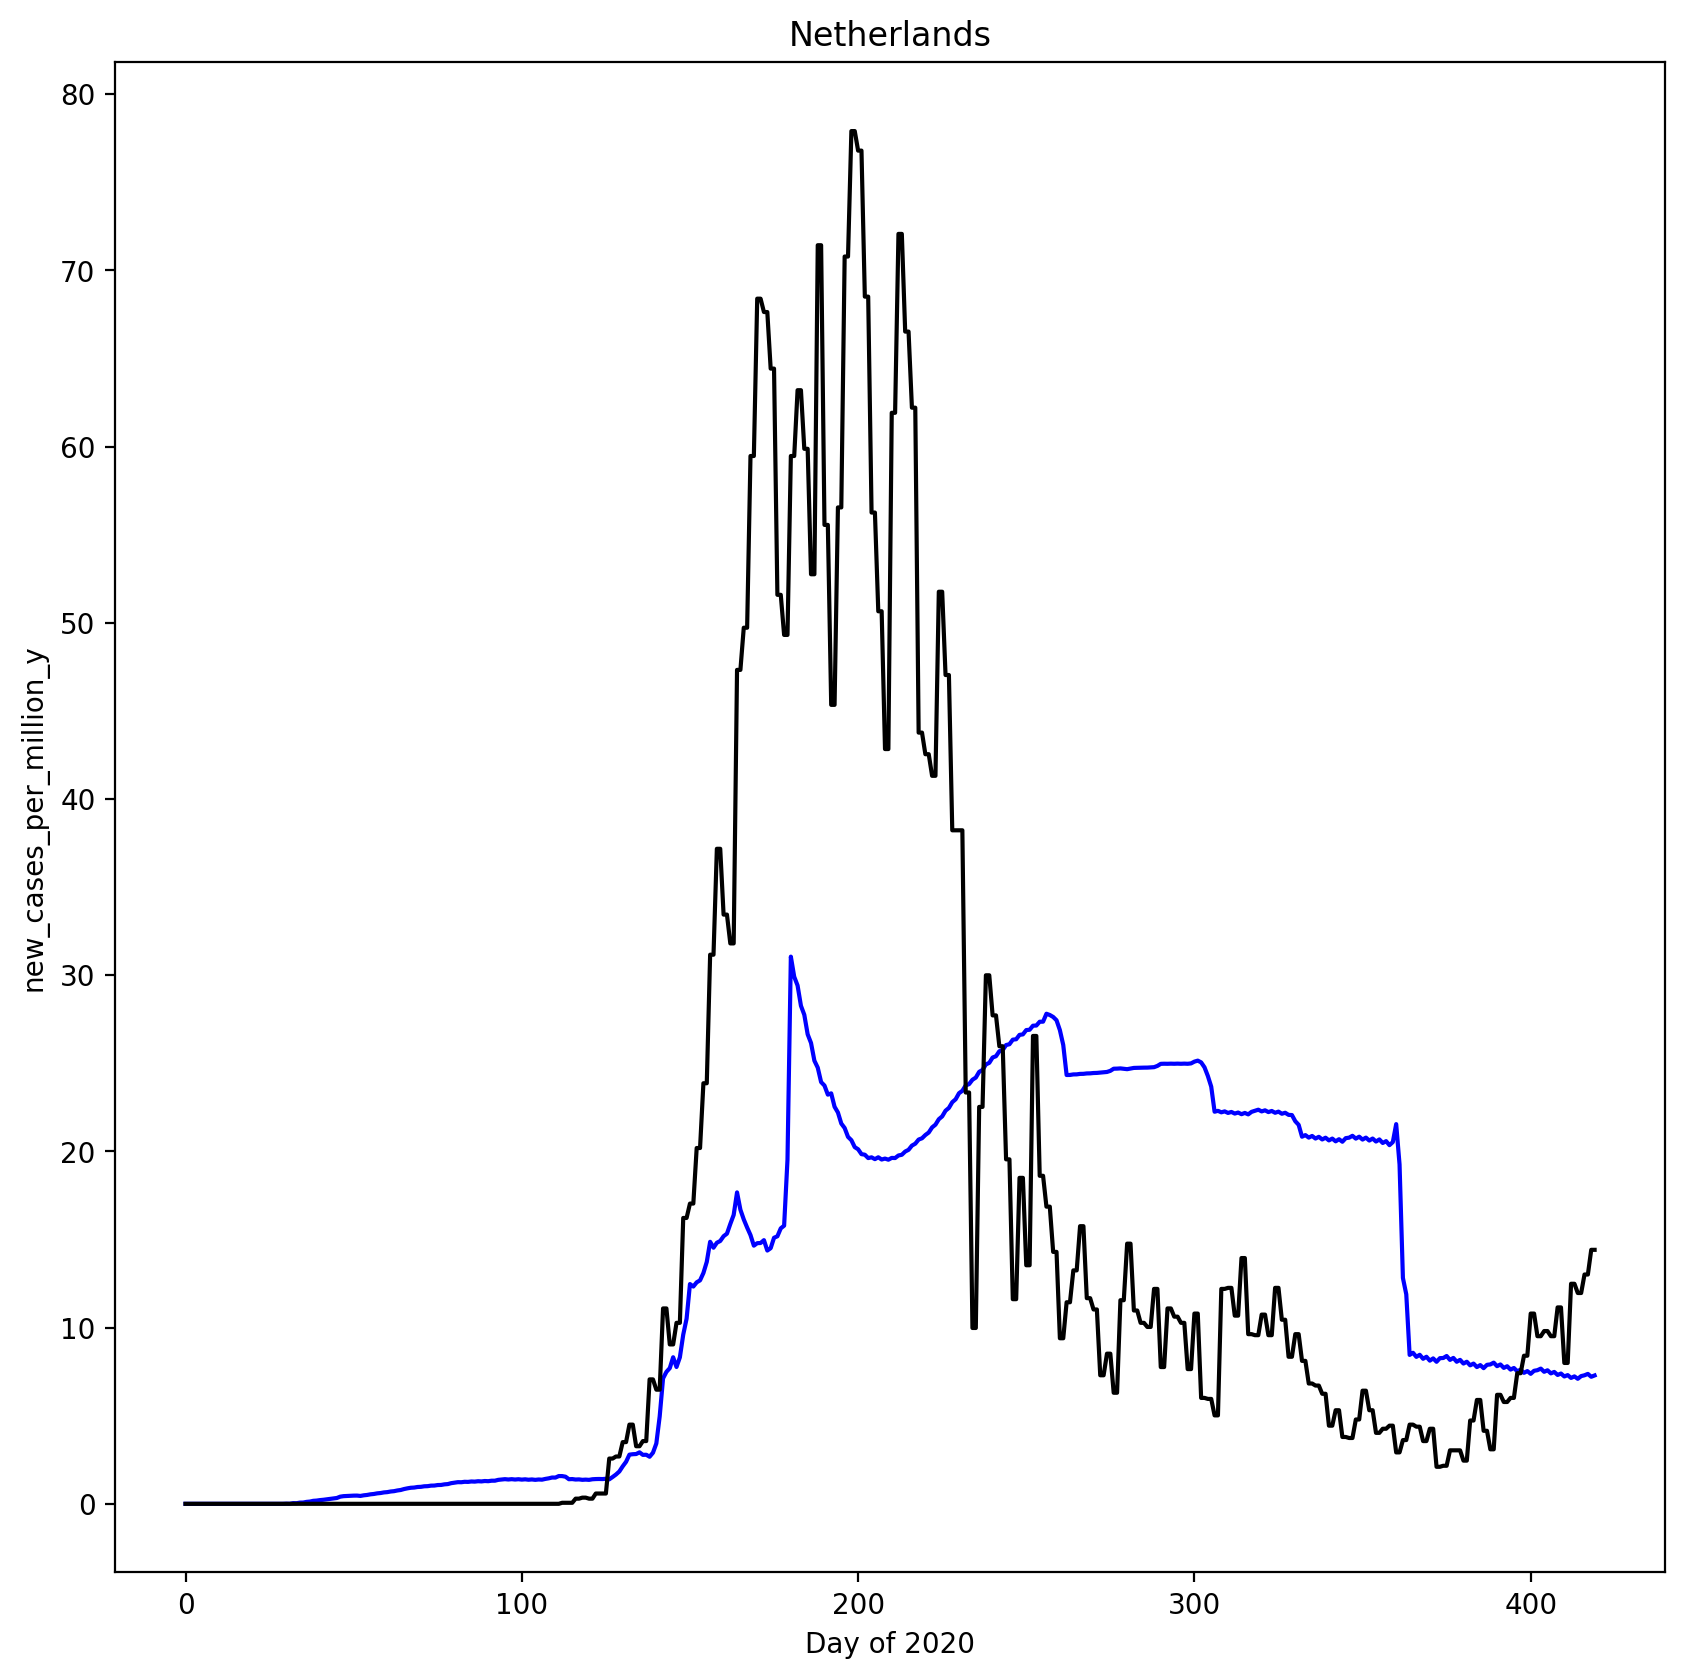

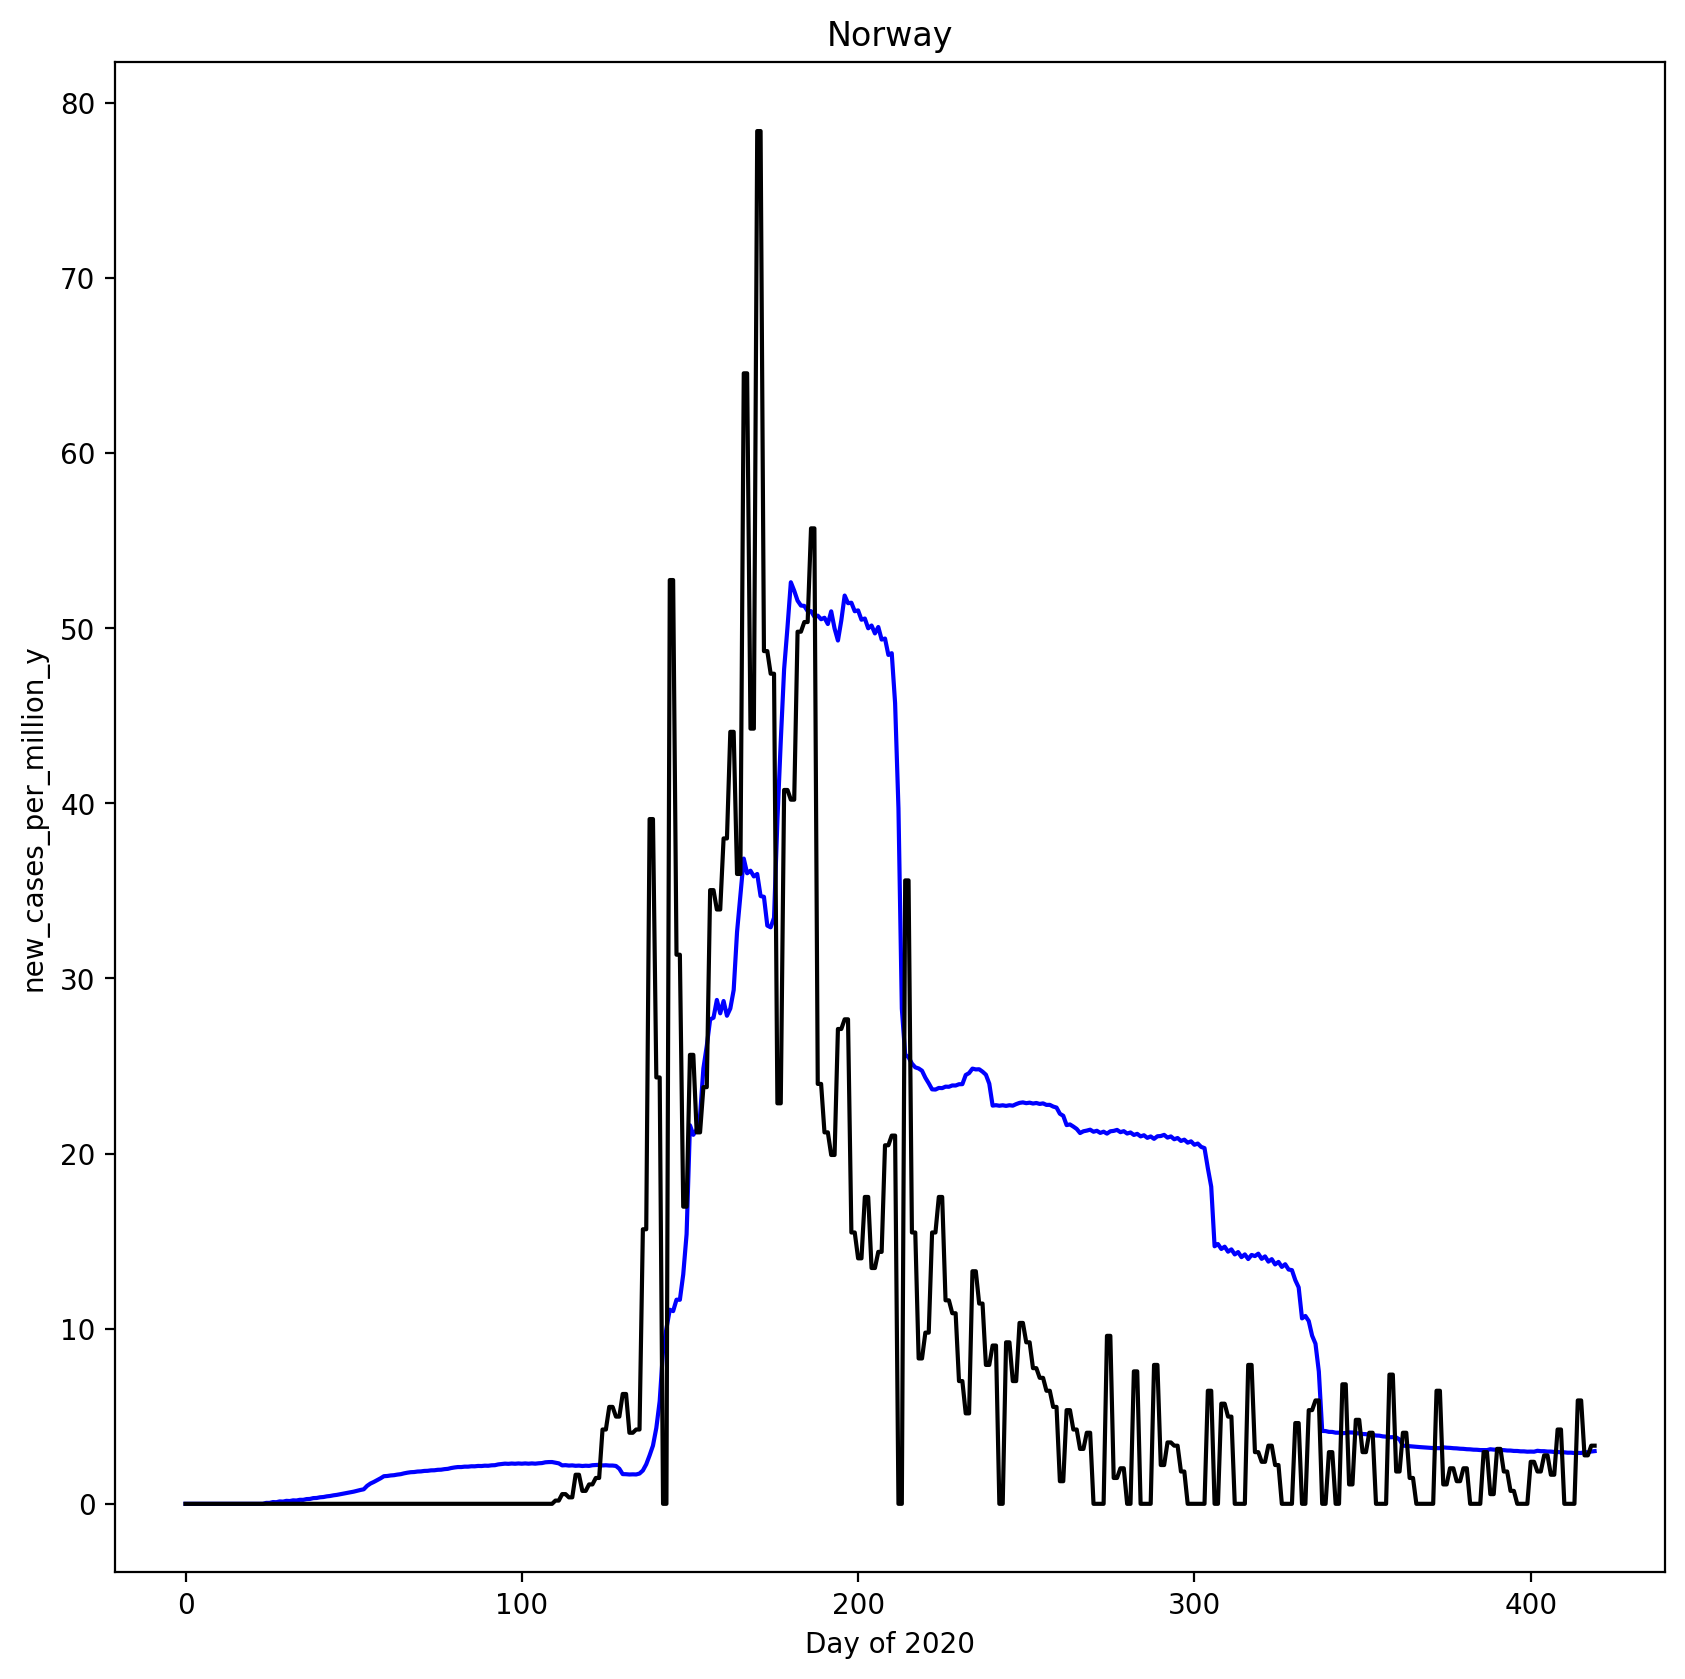

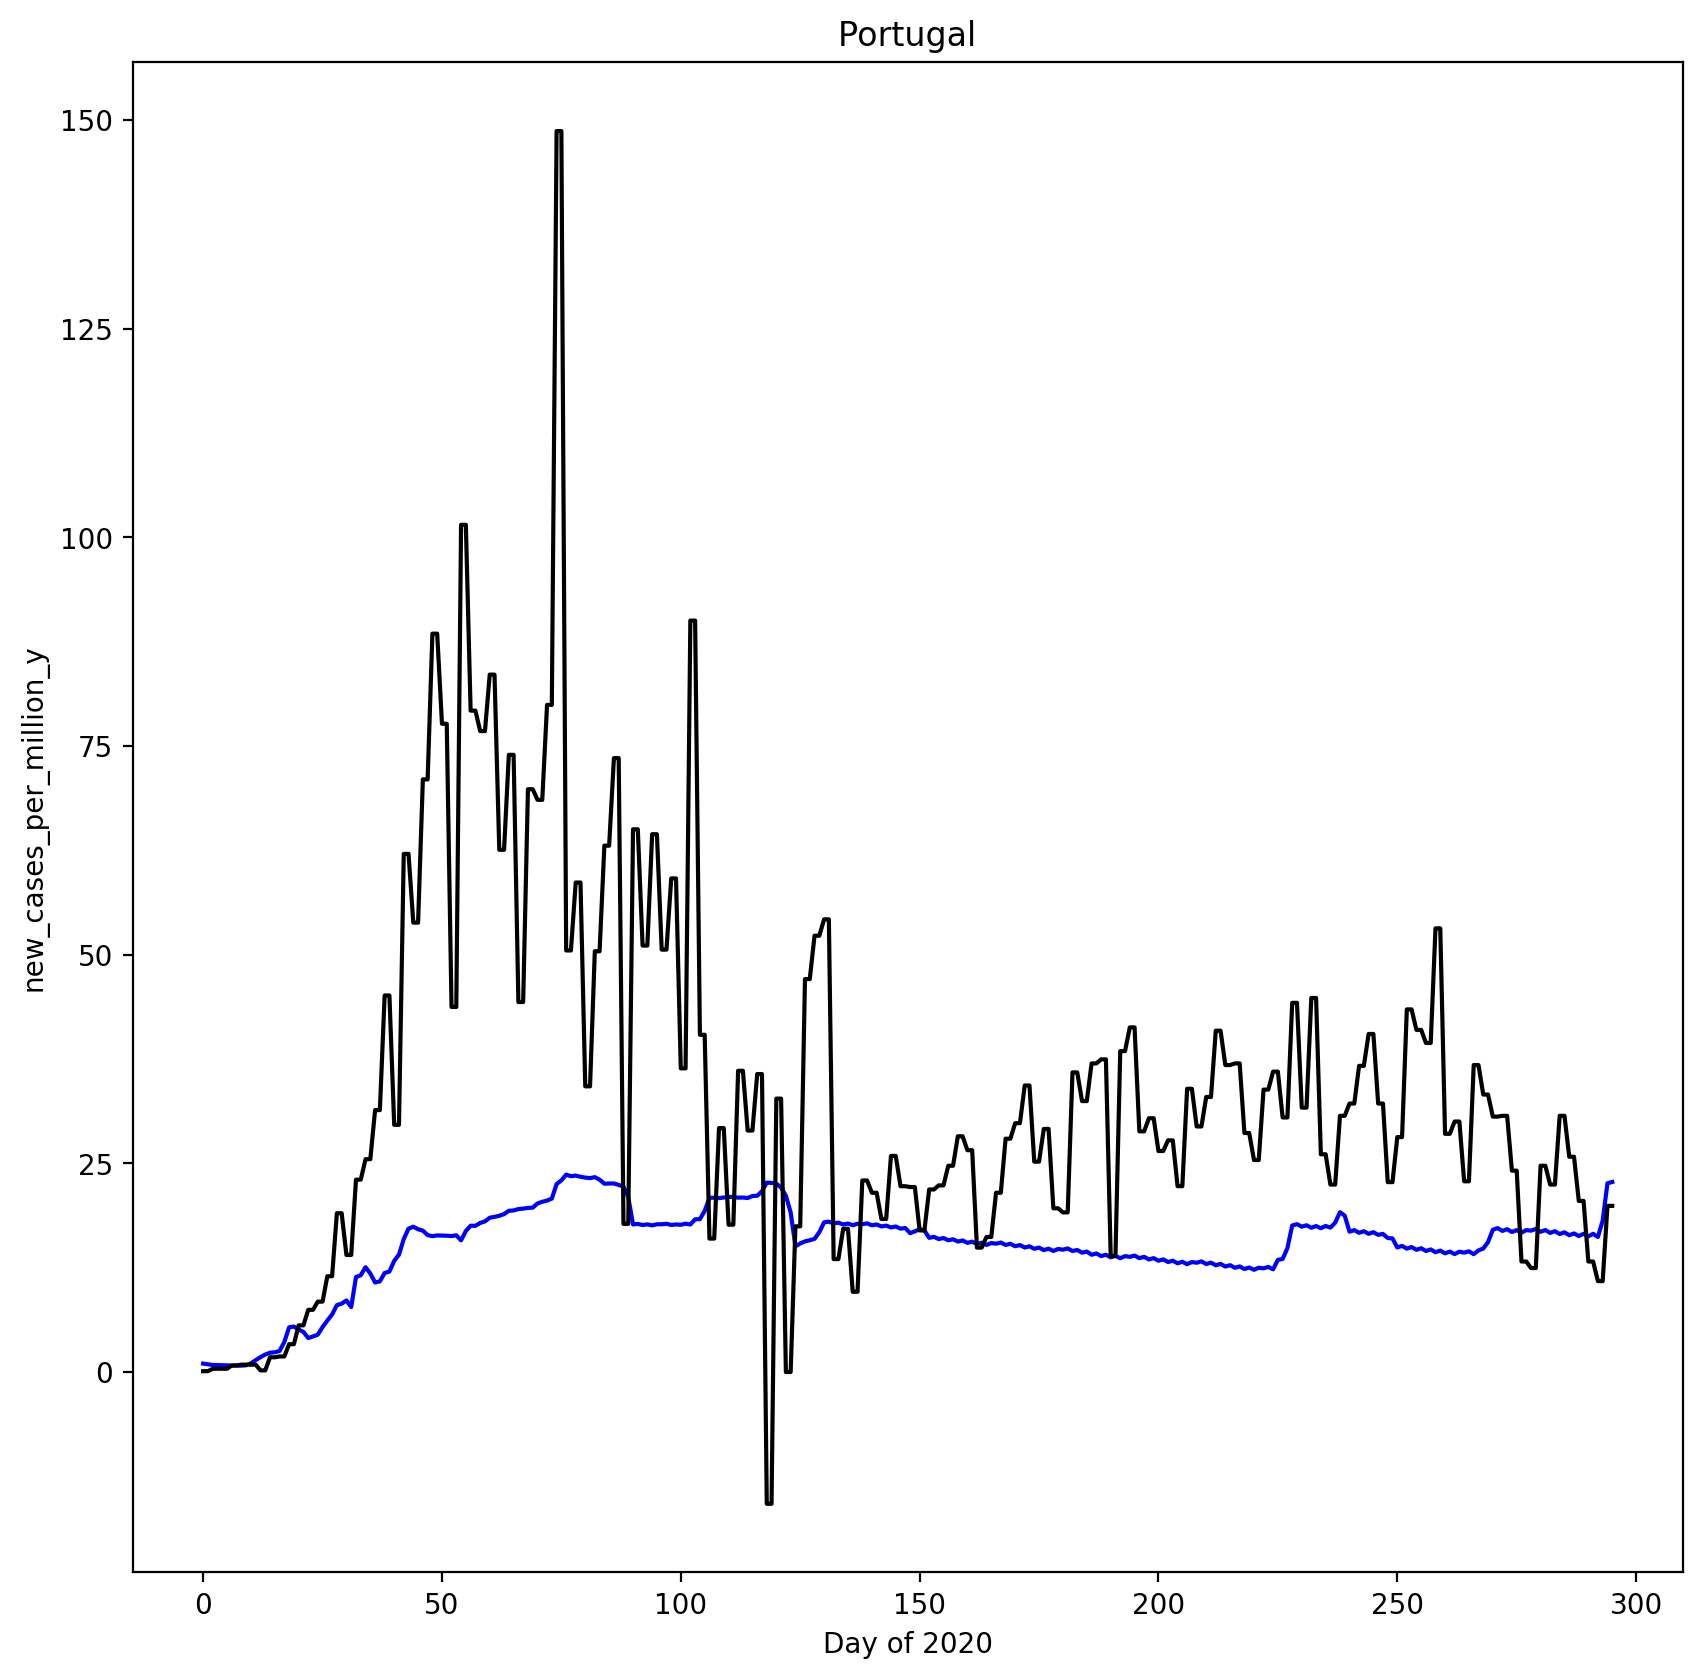

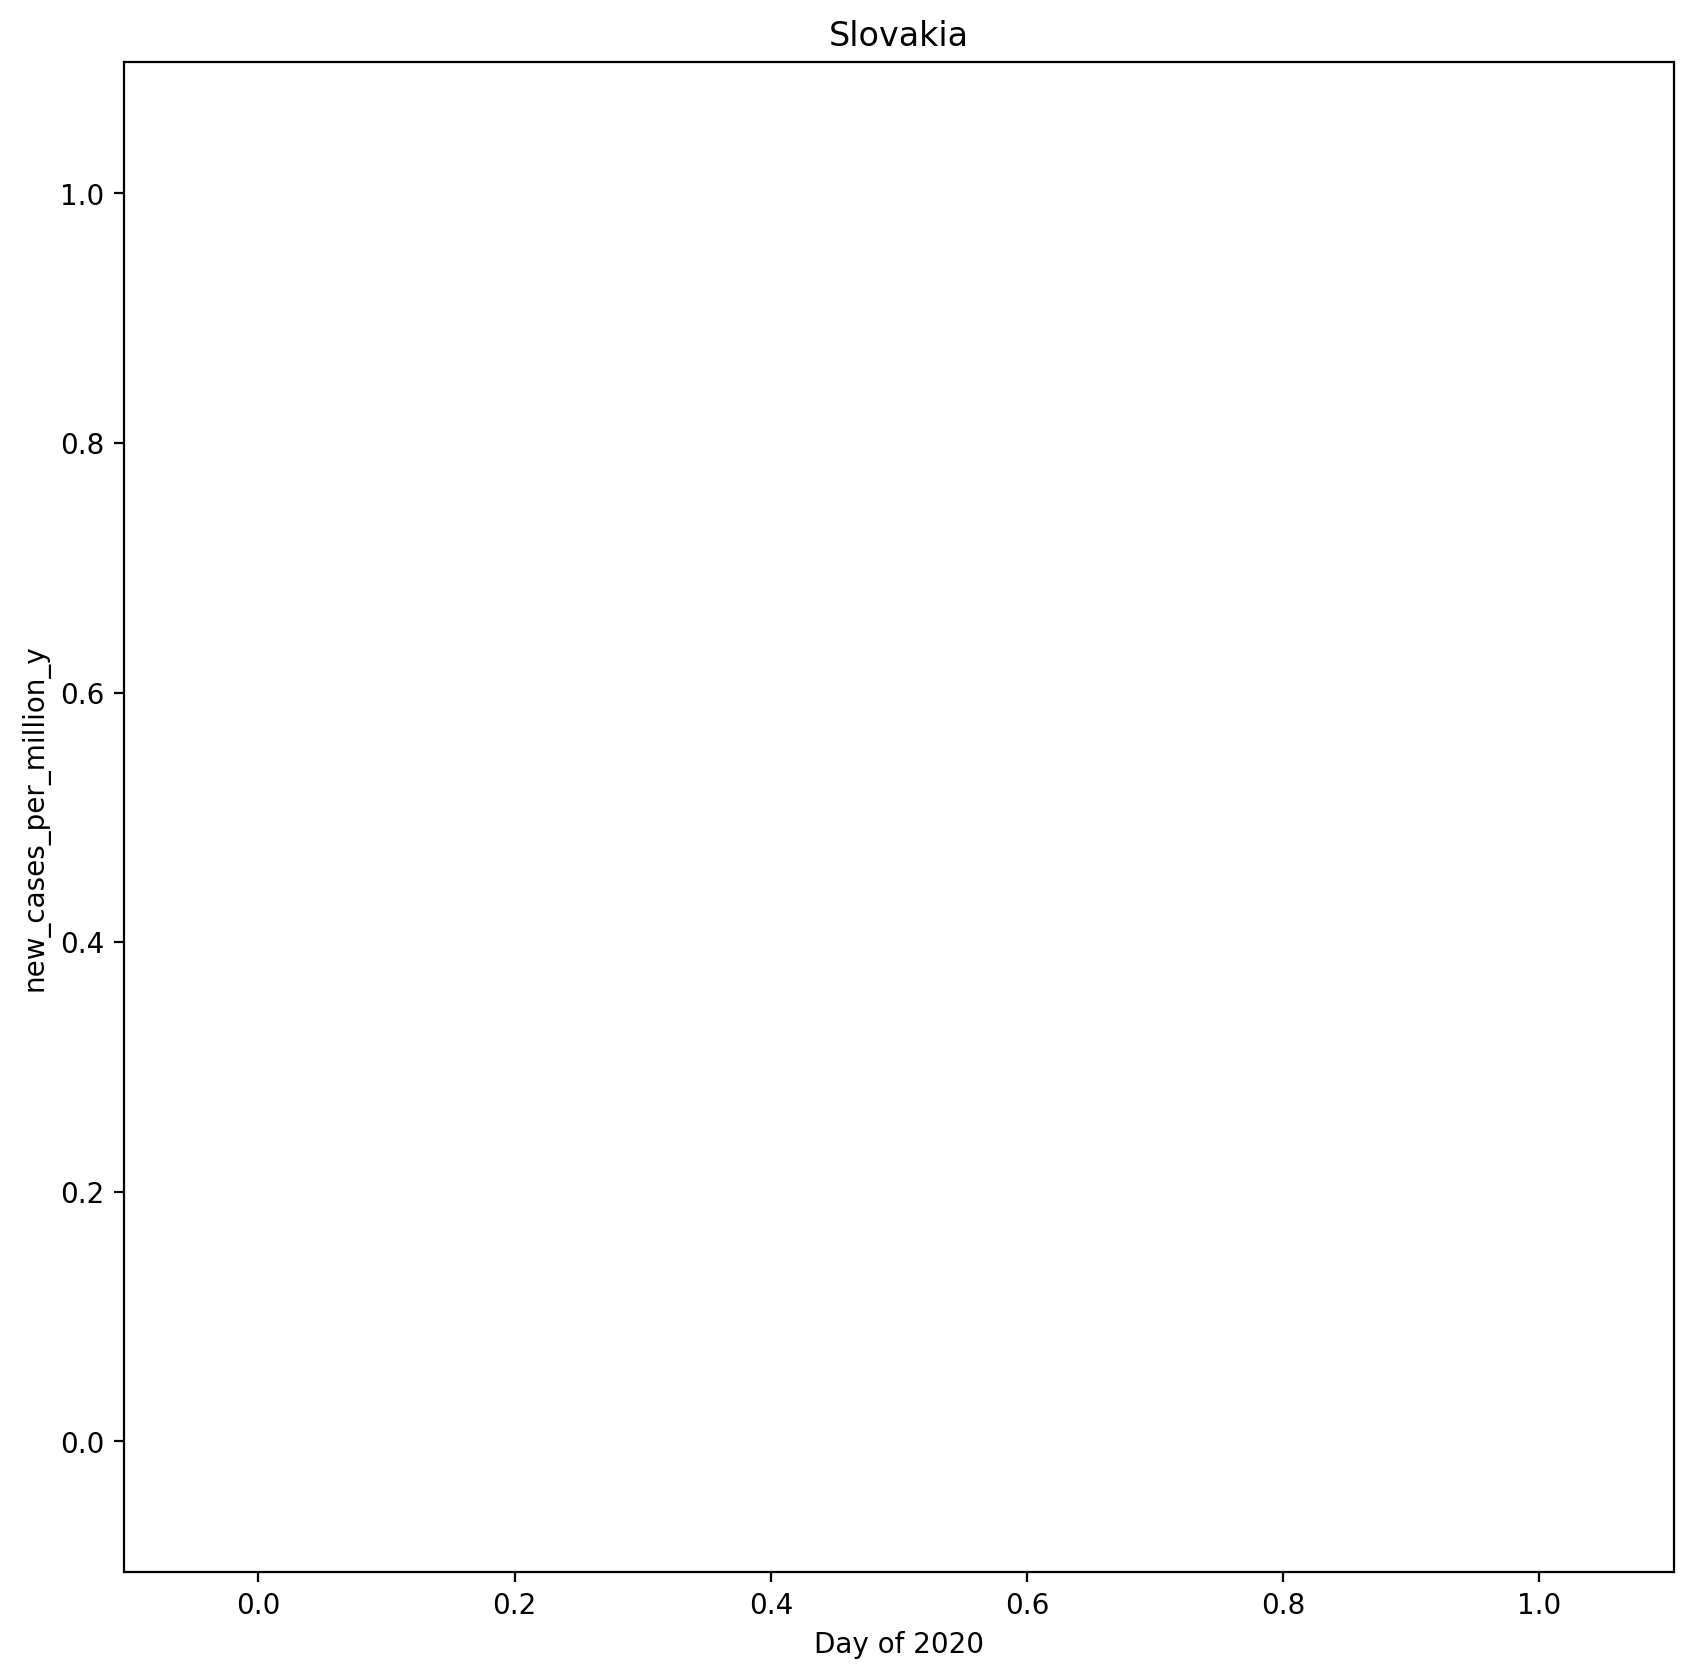

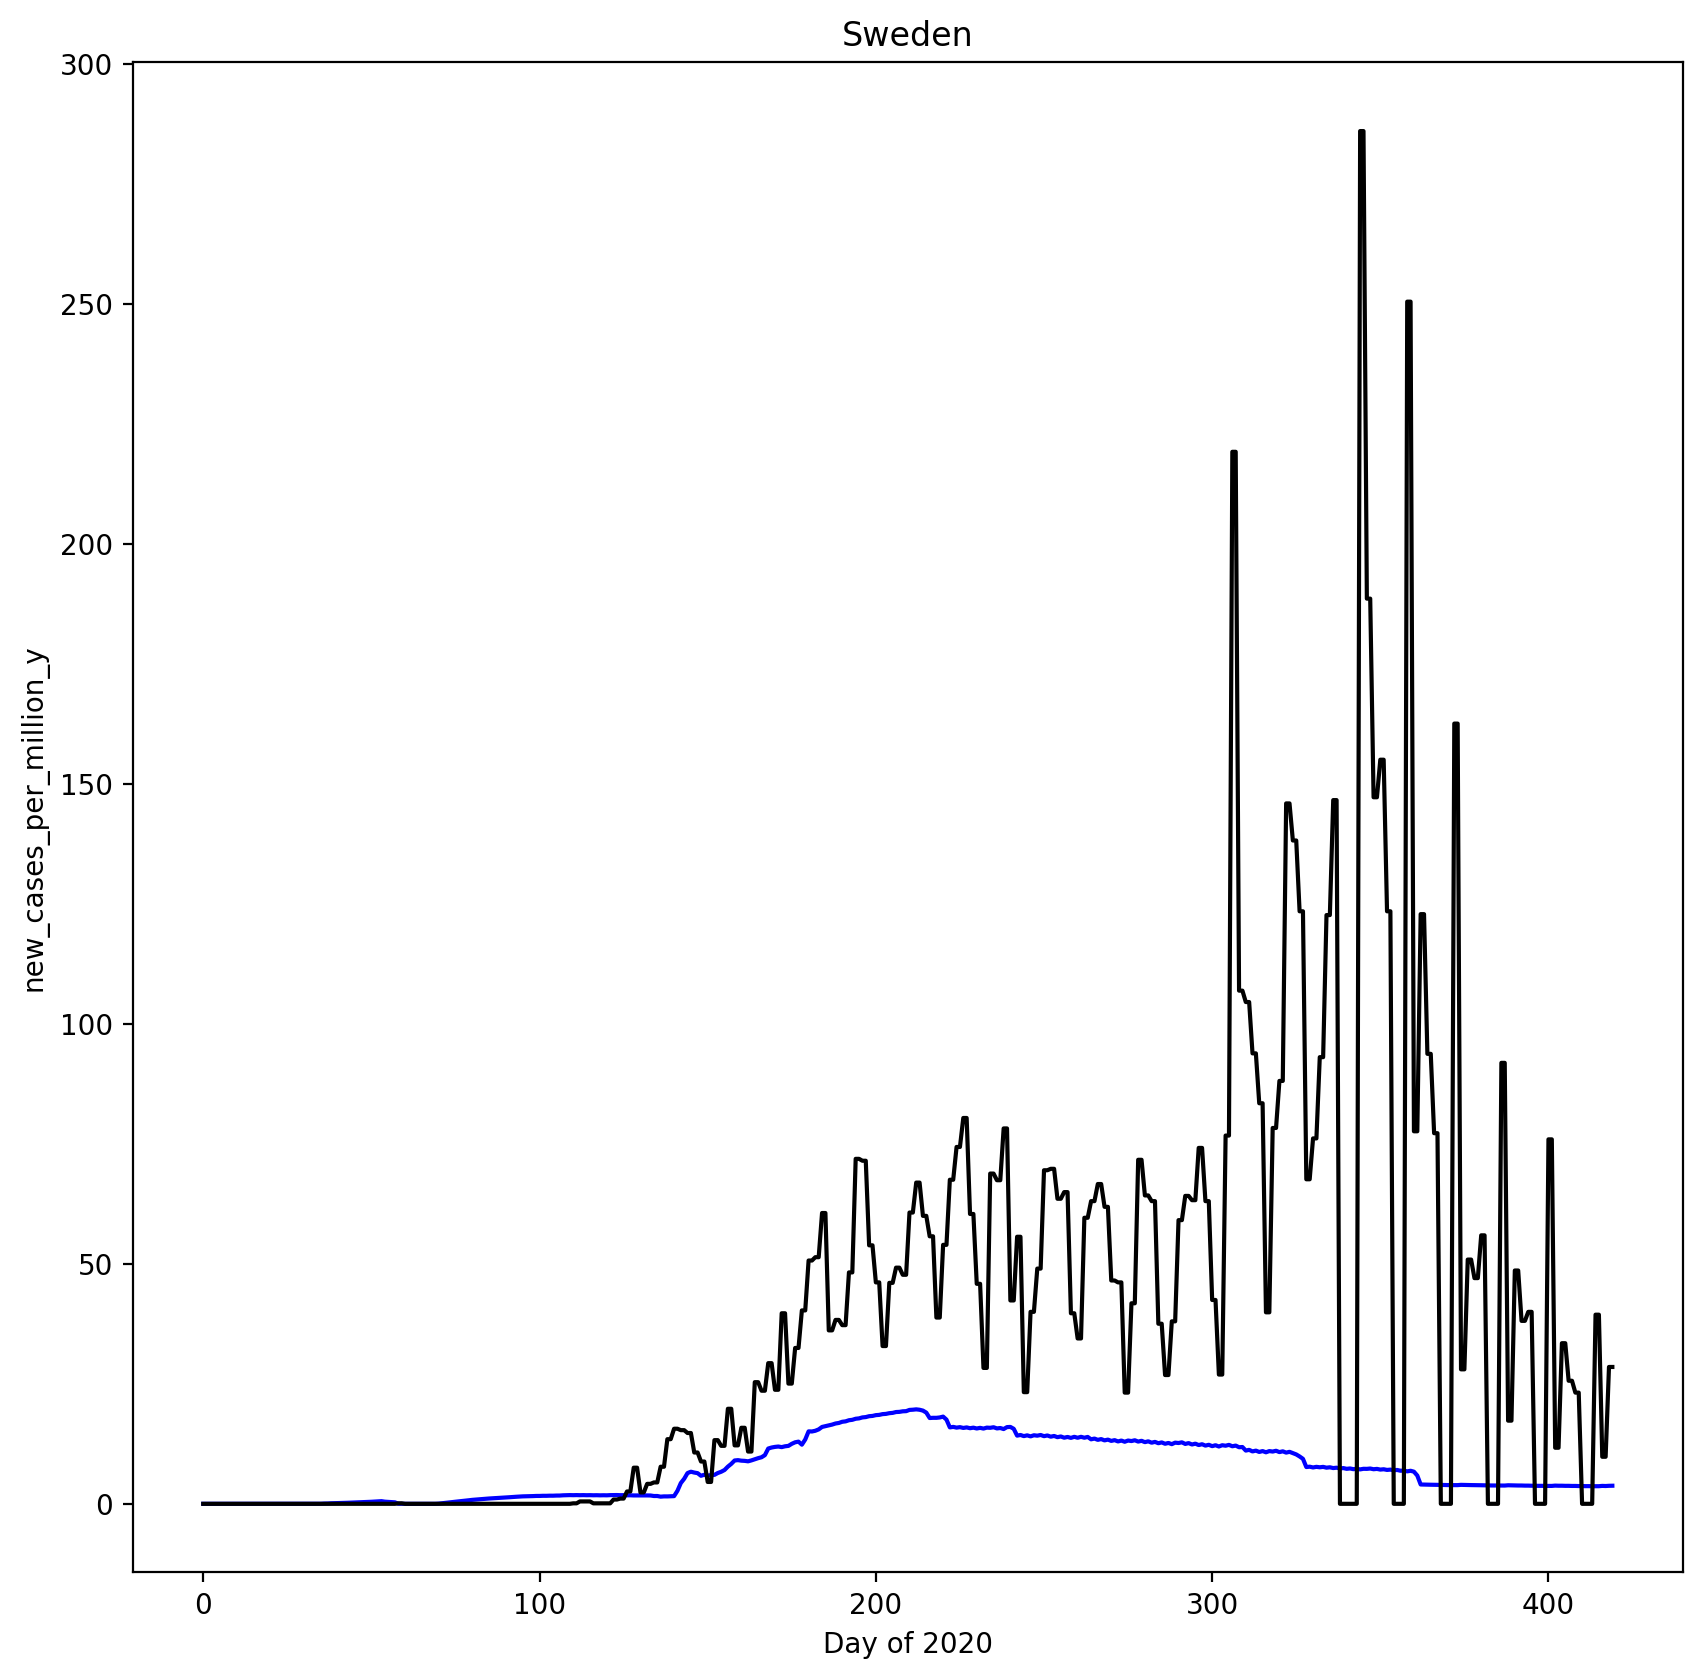

In [13]:
#list of countries:
C_list = cases['Country'].unique()

#num of countries:
num_countries = len(cases['Country'].unique())

#do a Test/train split:
lim = int(num_countries * 0.7)


###########################################
### PARAMS ################################r= 0.001 | n_steps= 4 | hidden size= 25 | epochs= 50
###########################################
NumberOfSteps = [7]#[3,4,7,9,14]
LearningRates = [0.001]#[0.001, 0.0015, 0.002, 0.00075]
LSTMSizes = [25]#[25, 50, 100, 200] 
Epochs = [100]#[50, 120, 200]
Plot = True
BatchSizes=[264]

FEATURES = [*range(5,27),31,*range(60,93),106,109,110,114]#[2,10,36, 21, 37,35,29,15]
n_features = len(FEATURES)

PREDICTION = 96#96 #or 101 ??
############################################
# Testing Loss
mse = tf.keras.losses.MeanSquaredError()


#############################################
### Loop de Loops beginns ###################
#############################################

country = cases[cases['Country']=='Germany']
print('Using the foloowing Features to learn:')
for i in FEATURES:
    print(country.columns[i])

low_loss = 999999999

for lr in LearningRates:
    for BS in BatchSizes:
        for n_steps in NumberOfSteps:
            for LSTM_hidden_size in LSTMSizes:
                for train_epochs in Epochs:


                    # define model
                    model = Sequential()
                    model.add(LSTM(LSTM_hidden_size, activation='relu', input_shape=(n_steps, n_features)))
                    model.add(Dense(1))
                    opt = keras.optimizers.Adam(learning_rate=lr)
                    cosine_loss = tf.keras.losses.CosineSimilarity(axis=0)
                    #model.compile(optimizer='adam', loss=cosine_loss) #default LR = 0.001
                    model.compile(optimizer=opt, loss='mse')

                    print('**Training started with following params: lr=',lr,'| n_steps=',n_steps,'| hidden size=',LSTM_hidden_size,'| epochs=', train_epochs)
                    start = time.time()
                    for c in C_list[0:lim]:
                        country = cases[cases['Country']==c]
                        print('Training on: ', c)
                        # define input sequence
                        in_seq = {}
                        dataset = []

                        for idx, i in enumerate(FEATURES):
                            #print(i, country.columns[i])
                            in_seq[idx] = np.asarray(country.values[:, [i]])
                            in_seq[idx] = in_seq[idx].reshape((len(in_seq[idx]), 1))


                        dataset = hstack((in_seq[0], in_seq[1]))

                        for o in range(2,len(in_seq)):
                            dataset = hstack((dataset, in_seq[o]))

                        out_seq = np.asarray(country.values[:, [PREDICTION]])
                        dataset = hstack((dataset, out_seq))

                        # convert into input/output
                        X, y = split_sequences(dataset, n_steps)


                        X = tf.convert_to_tensor(X, tf.int32)
                        # the dataset knows the number of features, e.g. 2
                        n_features = X.shape[2]
                        #print(n_features)
                        model.reset_states()
                        history = model.fit(X, y, batch_size=BS, epochs=train_epochs, verbose=0)

                        if Plot:
                            plt.figure(1)  

                             # summarize history for accuracy  

                            print(history.history.keys())  

                            plt.plot(history.history['loss'])  
                            plt.title('model loss')  
                            plt.ylabel('loss')  
                            plt.xlabel('epoch')  
                            plt.legend(['train'], loc='upper left')  
                            plt.show()  



                    end = time.time()
                    print('**Training Completed, elapsed time:',end - start,'**')
                    print('**Testing Started**')
                    a_err = [];


                    for c in C_list[lim:]:
                        country = cases[cases['Country']==c]
                        print('Testing on: ', c)
                        # define input sequence
                        in_seq = {}
                        dataset = []
                        res = []
                        for idx, i in enumerate(FEATURES):
                            #print(i, country.columns[i])
                            in_seq[idx] = np.asarray(country.values[:, [i]])
                            in_seq[idx] = in_seq[idx].reshape((len(in_seq[idx]), 1))


                        dataset = hstack((in_seq[0], in_seq[1]))

                        for o in range(2,len(in_seq)):
                            dataset = hstack((dataset, in_seq[o]))

                        out_seq = np.asarray(country.values[:, [PREDICTION]])
                        dataset = hstack((dataset, out_seq))
                        #dataset = hstack((in_seq1, in_seq2, in_seq3))




                        # convert into input/output
                        X, y = split_sequences(dataset, n_steps)

                        #print(len(X))

                        for i in range(len(X)):
                            x_input = X[i].astype(np.float32)
                            x_input = x_input.reshape((1, n_steps, n_features))
                            yhat = model.predict(x_input, verbose=0)
                            #print(yhat[0])
                            res.append(max(yhat[0][0],0))



                        y = np.asarray(y).astype(np.float32)
                        res = np.asarray(res).astype(np.float32)


                        a_err.append(mse(y, res).numpy())

                        if Plot:

                            plt.figure(num=None, figsize=(10, 10), dpi=200, facecolor='w', edgecolor='k')
                            plt.plot(res,'b')
                            plt.plot(y,'k')
                            plt.title(c)
                            plt.ylabel(country.columns[PREDICTION])
                            plt.xlabel('Day of 2020')

                            plt.show

                    a_err = np.asarray(a_err)
                    a_err = np.mean(a_err[~np.isnan(a_err)])

                    if a_err < low_loss:
                        print('NEW BEST!!!')
                        low_loss = a_err

                    print('**Testing Completed**')
                    print('**Average Error:', a_err)




<a class="anchor" id="carbon"></a>
<h1>Carbon dioxide prediction</h1>

* Do test/train split
* define some parameters for hyperparam optimization
* Train the model
* Do Prediction on Testset

Using the foloowing Features to learn:
C1_School closing
C2_Workplace closing
C3_Cancel public events
C4_Restrictions on gatherings
C5_Close public transport
C6_Stay at home requirements
C7_Restrictions on internal movement
C8_International travel controls
E1_Income support
E2_Debt/contract relief
E3_Fiscal measures
E4_International support
H1_Public information campaigns
H2_Testing policy
H3_Contact tracing
H4_Emergency investment in healthcare
H5_Investment in vaccines
StringencyIndex
GovernmentResponseIndex
ContainmentHealthIndex
EconomicSupportIndex
DAY
year_week
Additional health/documents requirements upon arrival
Amendments to funeral and burial regulations
Awareness campaigns
Border checks 
Border closure 
Changes in prison-related policies
Checkpoints within the country
Closure of businesses and public services
Curfews
Domestic travel restrictions
Economic measures
Emergency administrative structures activated or established
Full lockdown
General recommendations
Health screeni

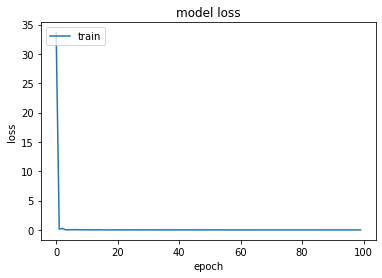

Training on:  Belgium
dict_keys(['loss'])


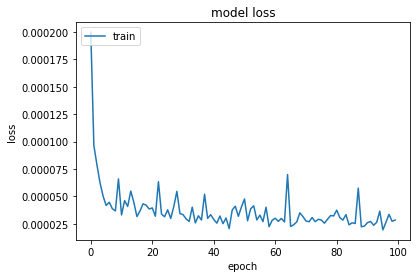

Training on:  Colombia
dict_keys(['loss'])


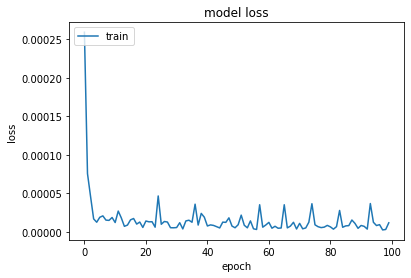

Training on:  Czech Republic
dict_keys(['loss'])


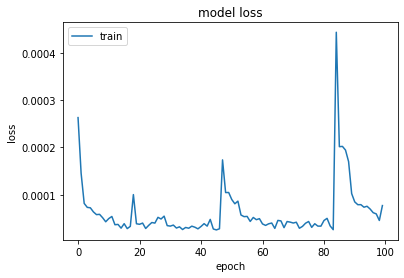

Training on:  Germany
dict_keys(['loss'])


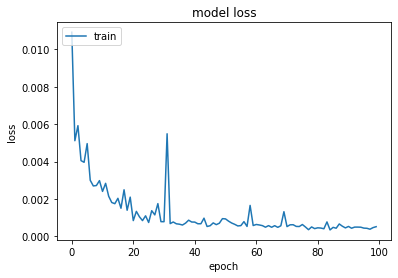

Training on:  Denmark
dict_keys(['loss'])


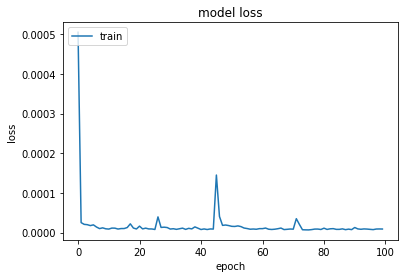

Training on:  Spain
dict_keys(['loss'])


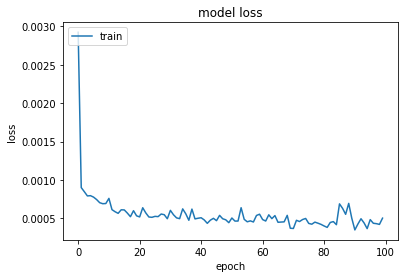

Training on:  Estonia
dict_keys(['loss'])


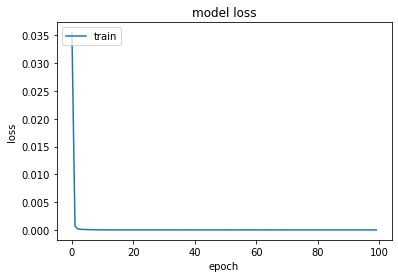

Training on:  Finland
dict_keys(['loss'])


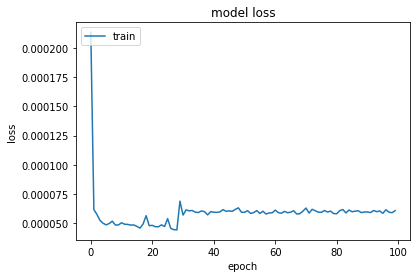

Training on:  France
dict_keys(['loss'])


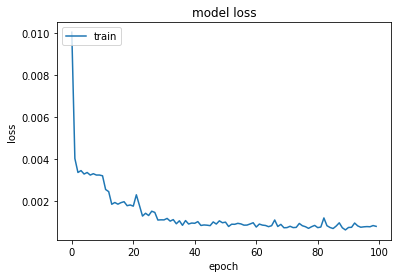

Training on:  United Kingdom
dict_keys(['loss'])


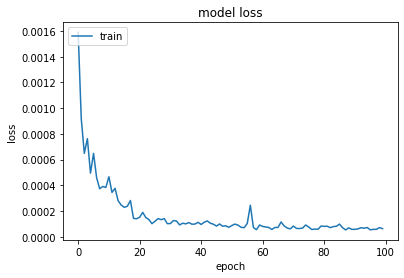

Training on:  Greece
dict_keys(['loss'])


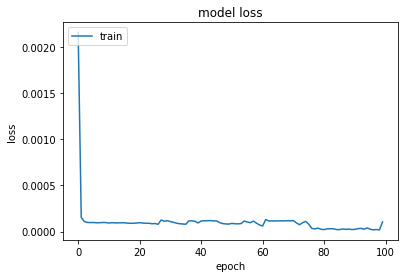

Training on:  Hungary
dict_keys(['loss'])


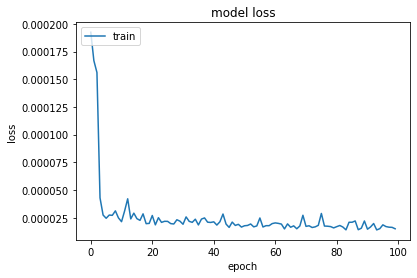

Training on:  Italy
dict_keys(['loss'])


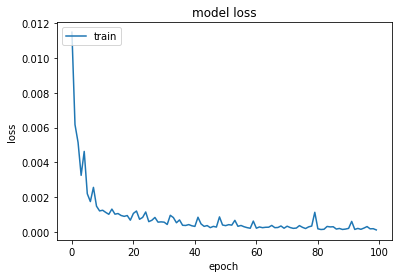

Training on:  Lithuania
dict_keys(['loss'])


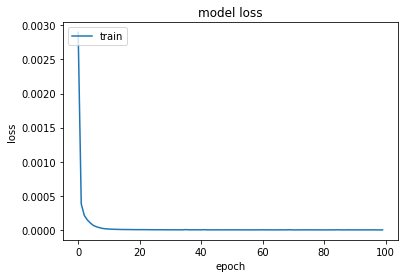

**Training Completed, elapsed time: 478.6695411205292 **
**Testing Started**
Testing on:  Luxembourg
Testing on:  Latvia
Testing on:  Netherlands
Testing on:  Norway
Testing on:  Portugal
Testing on:  Slovakia
Testing on:  Sweden
NEW BEST!!!
**Testing Completed**
**Average Error: 0.0011194436


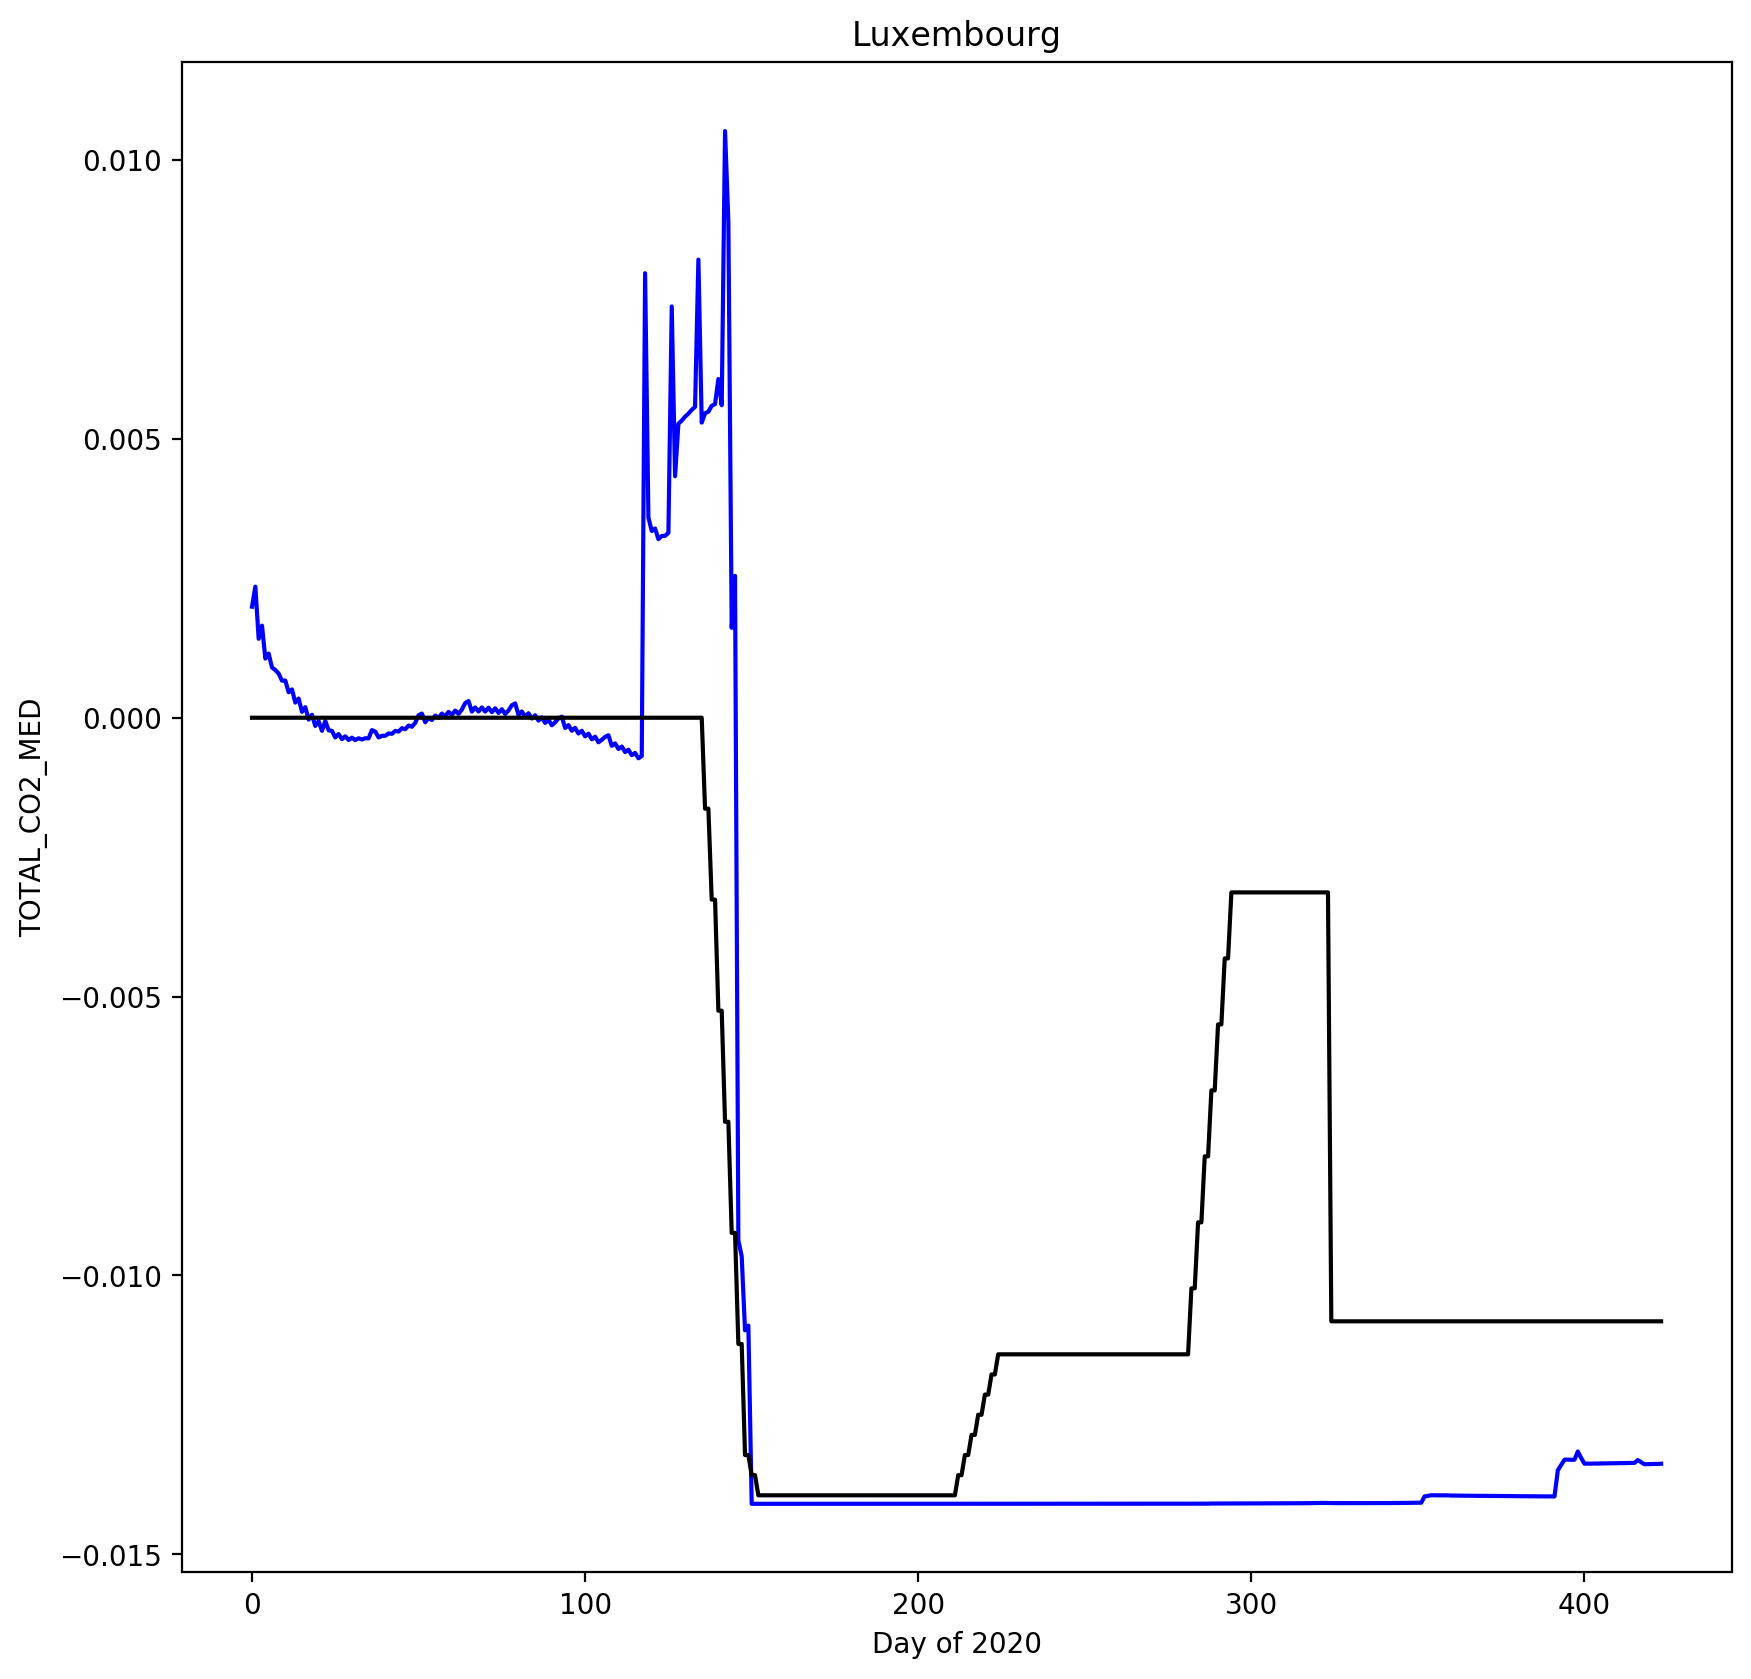

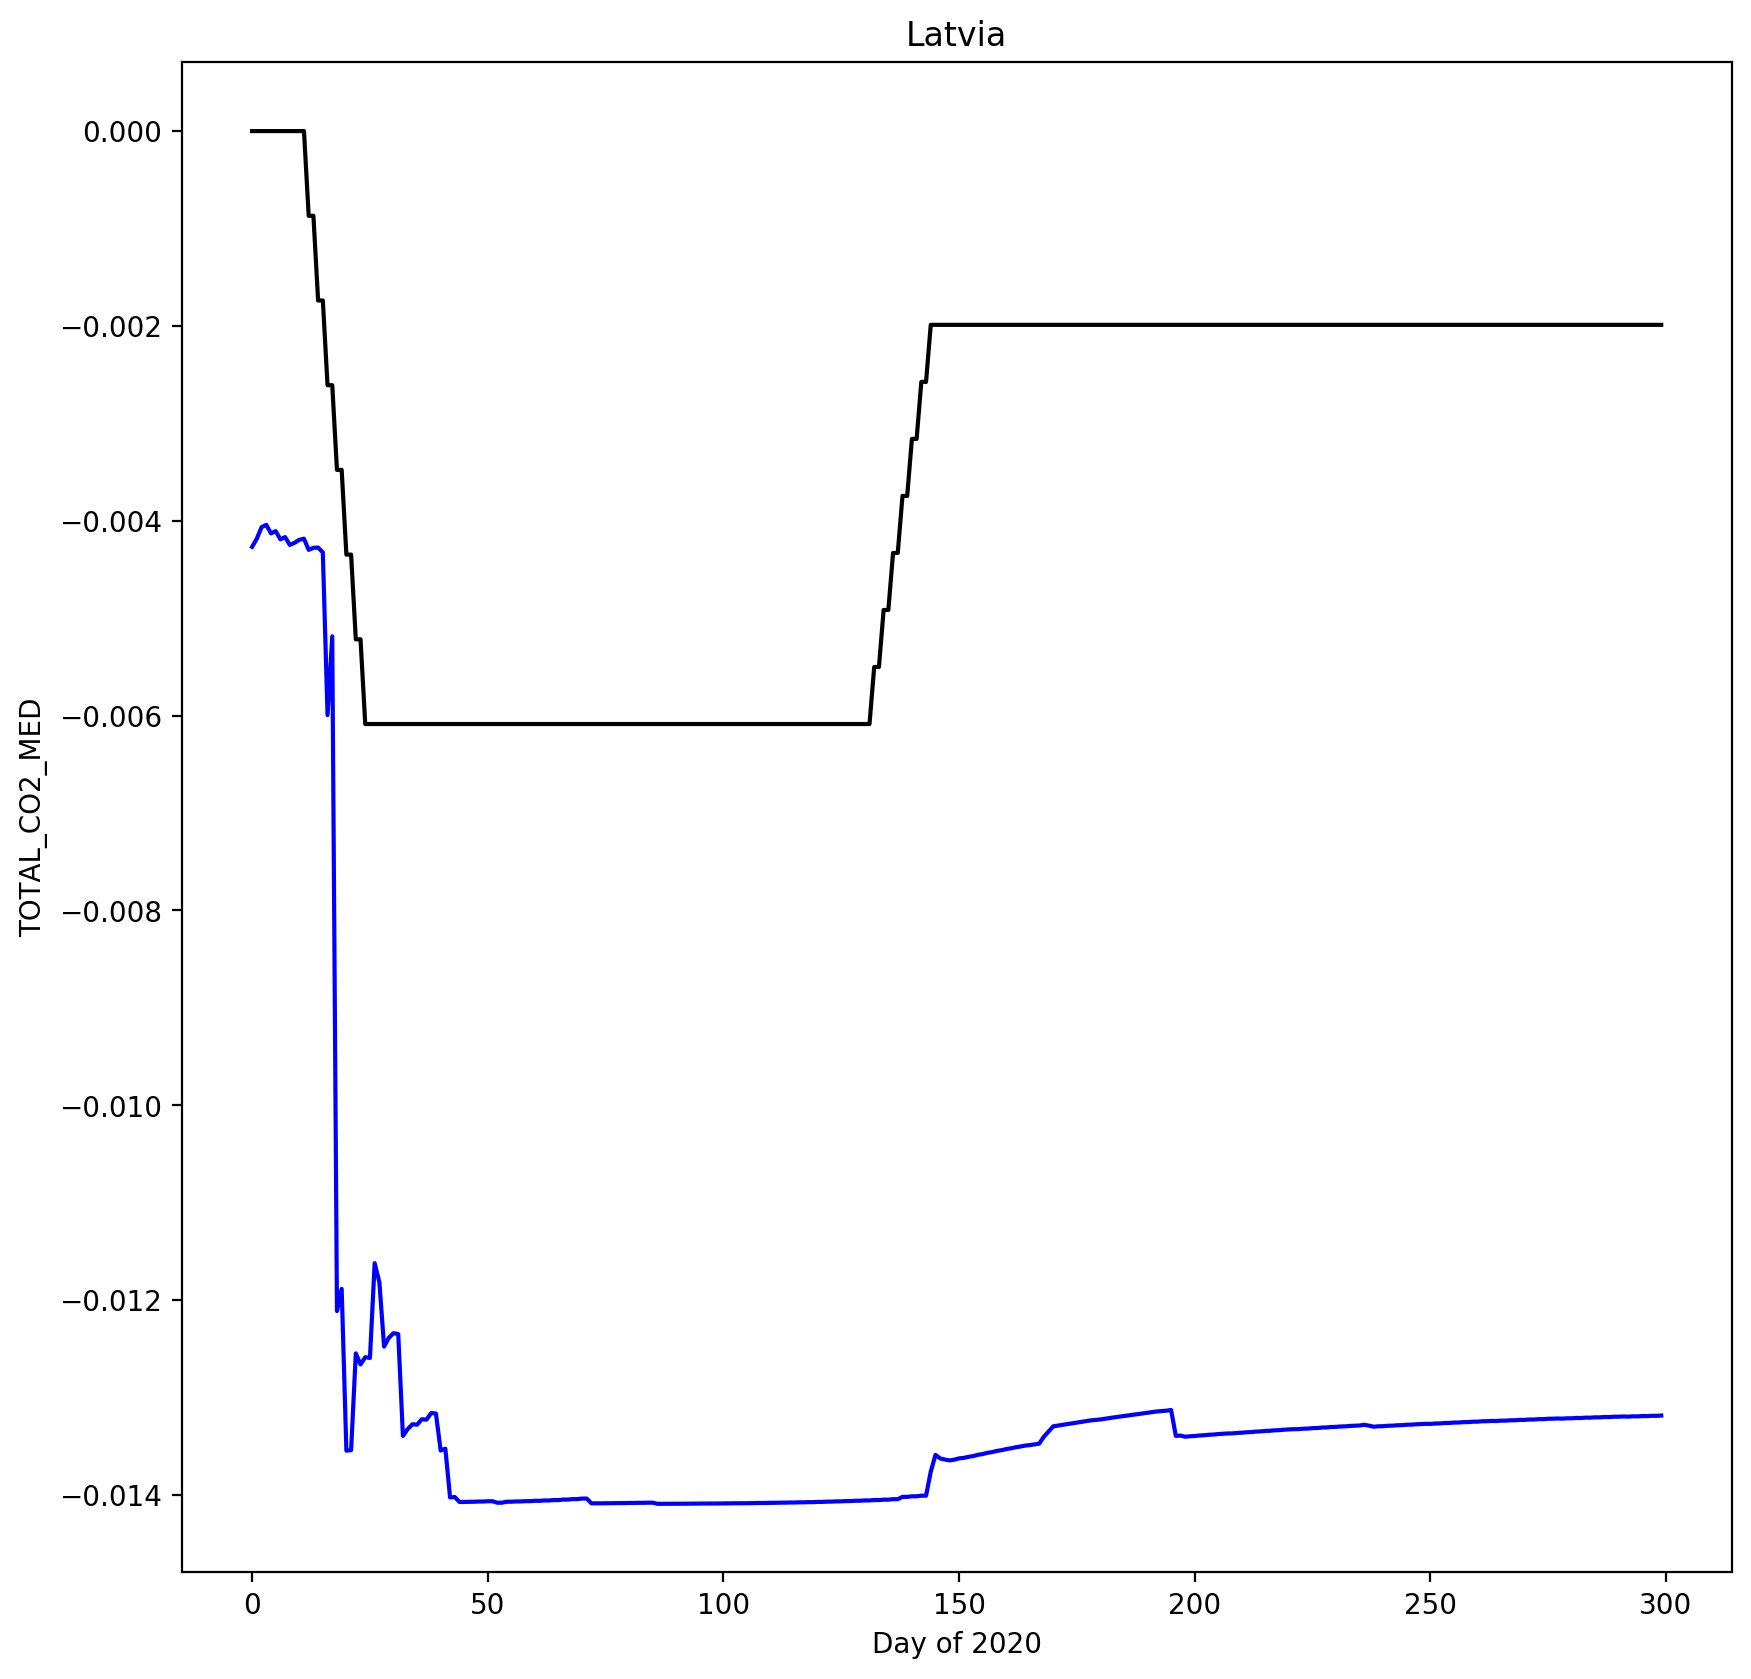

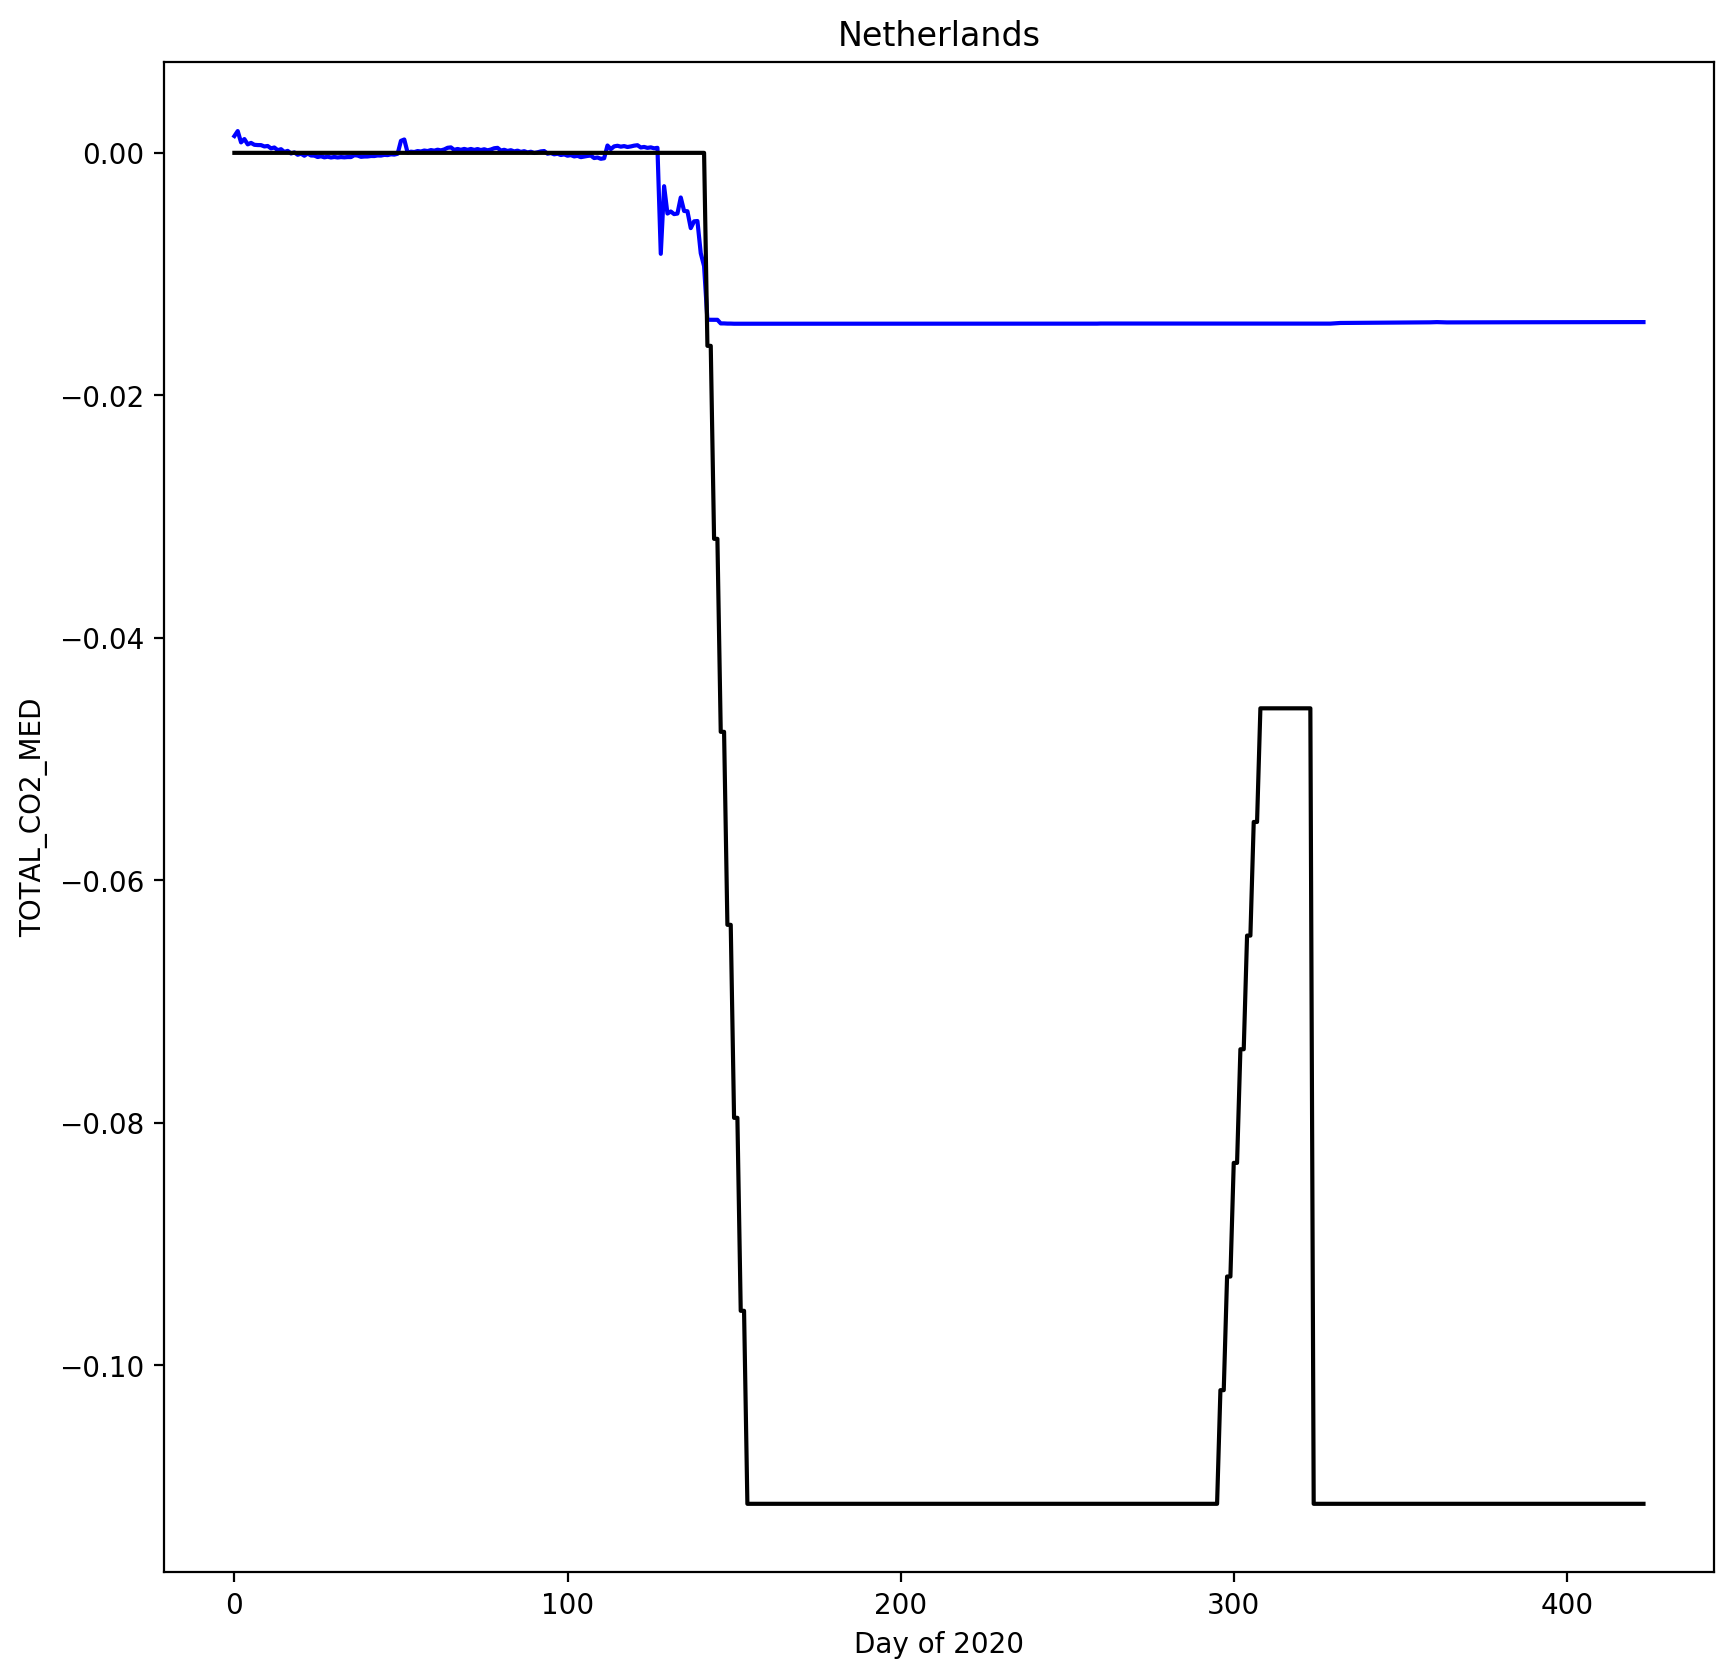

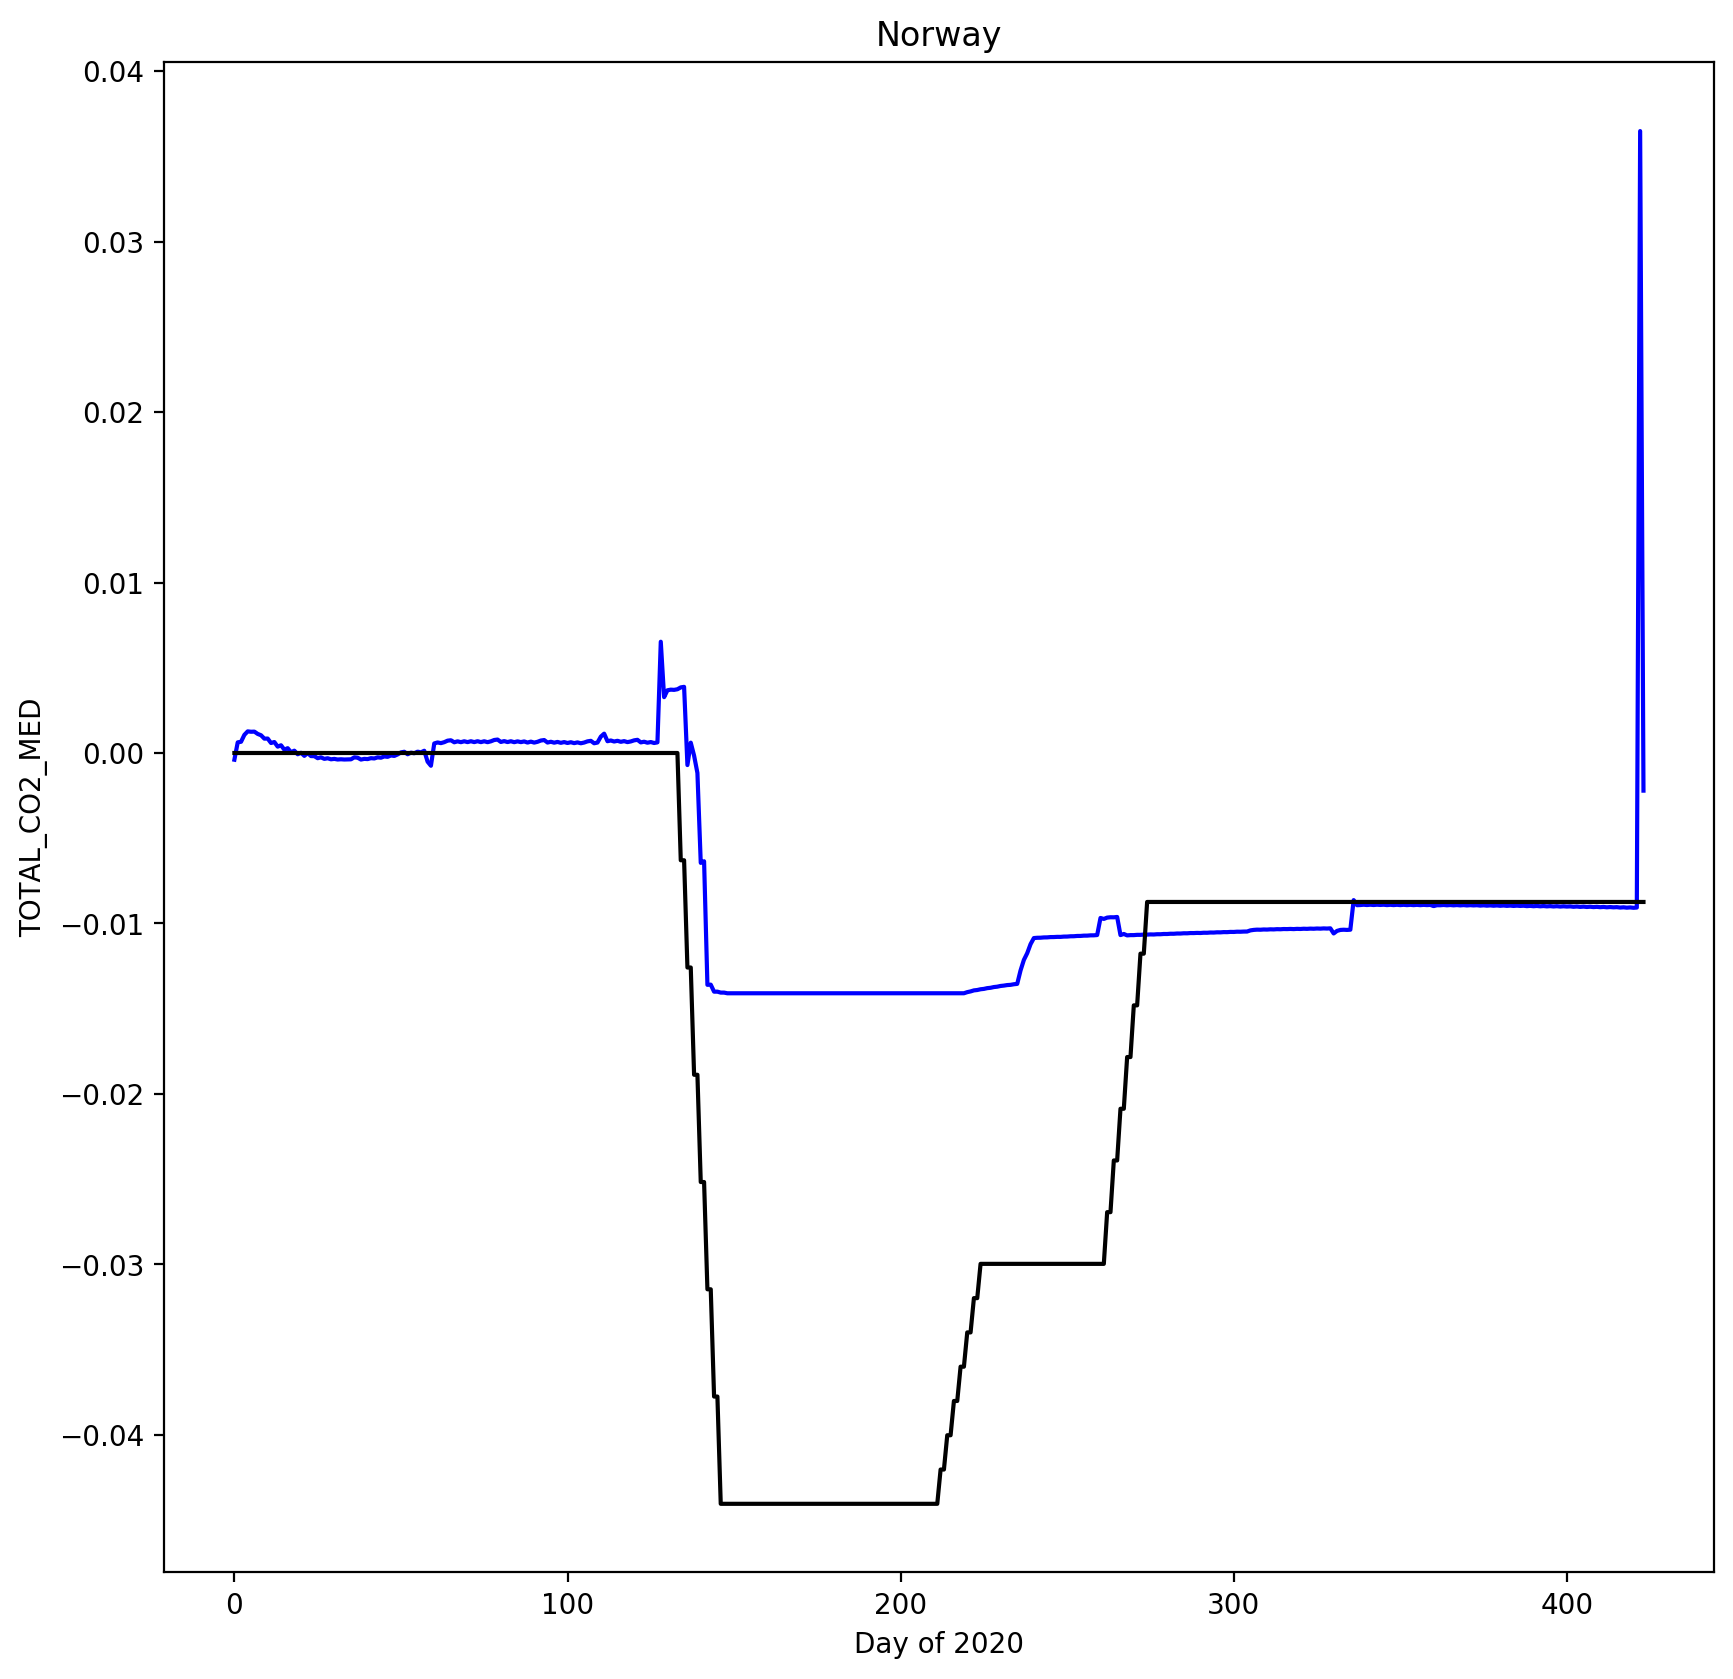

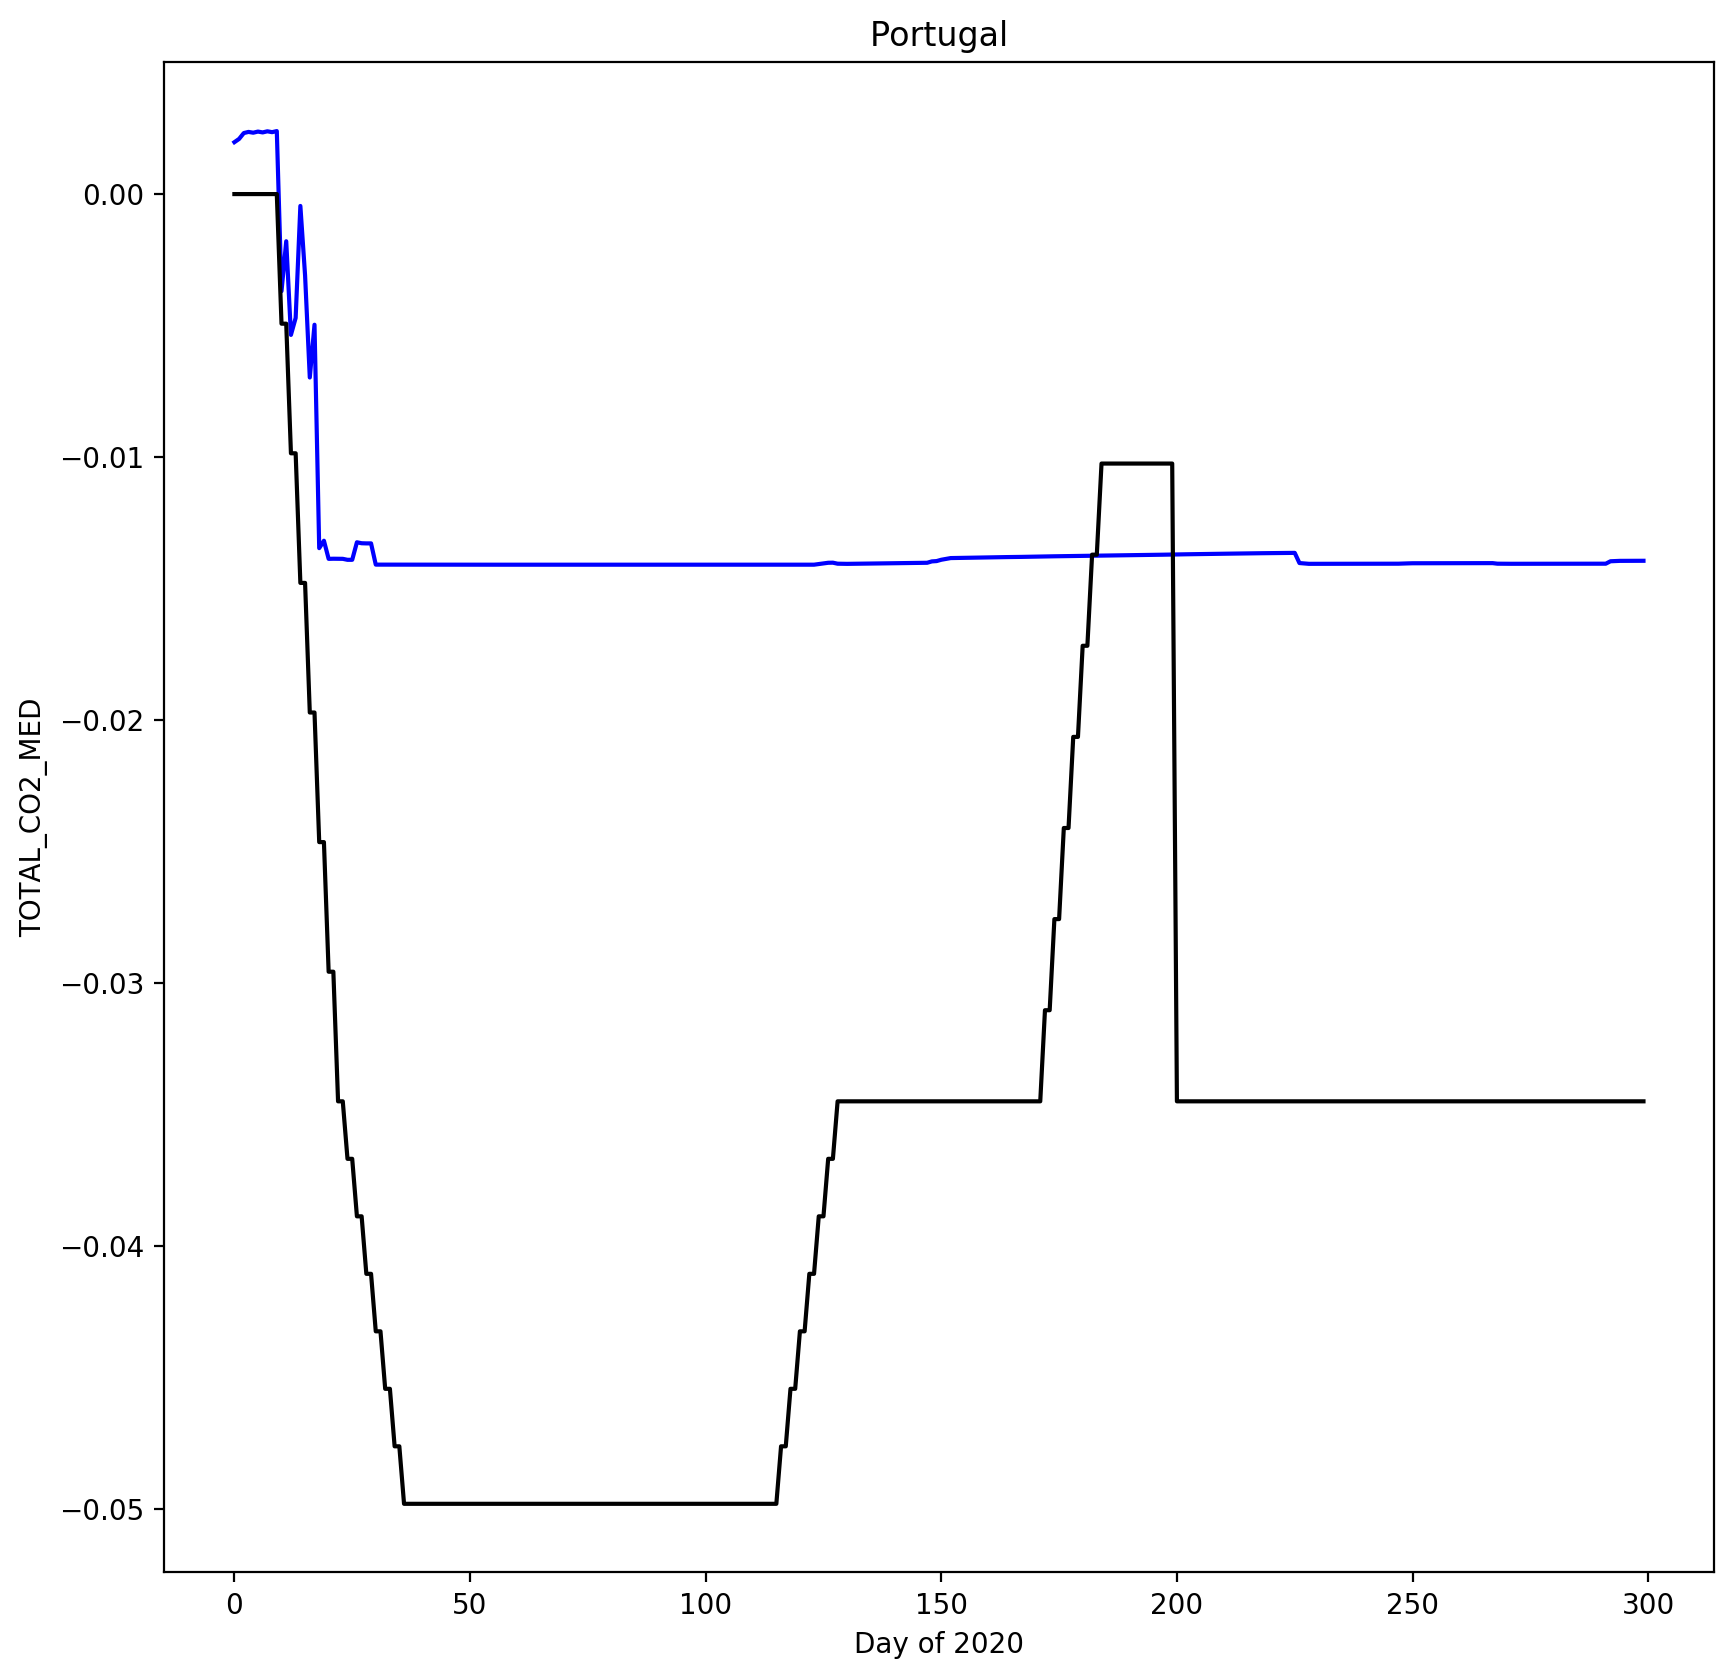

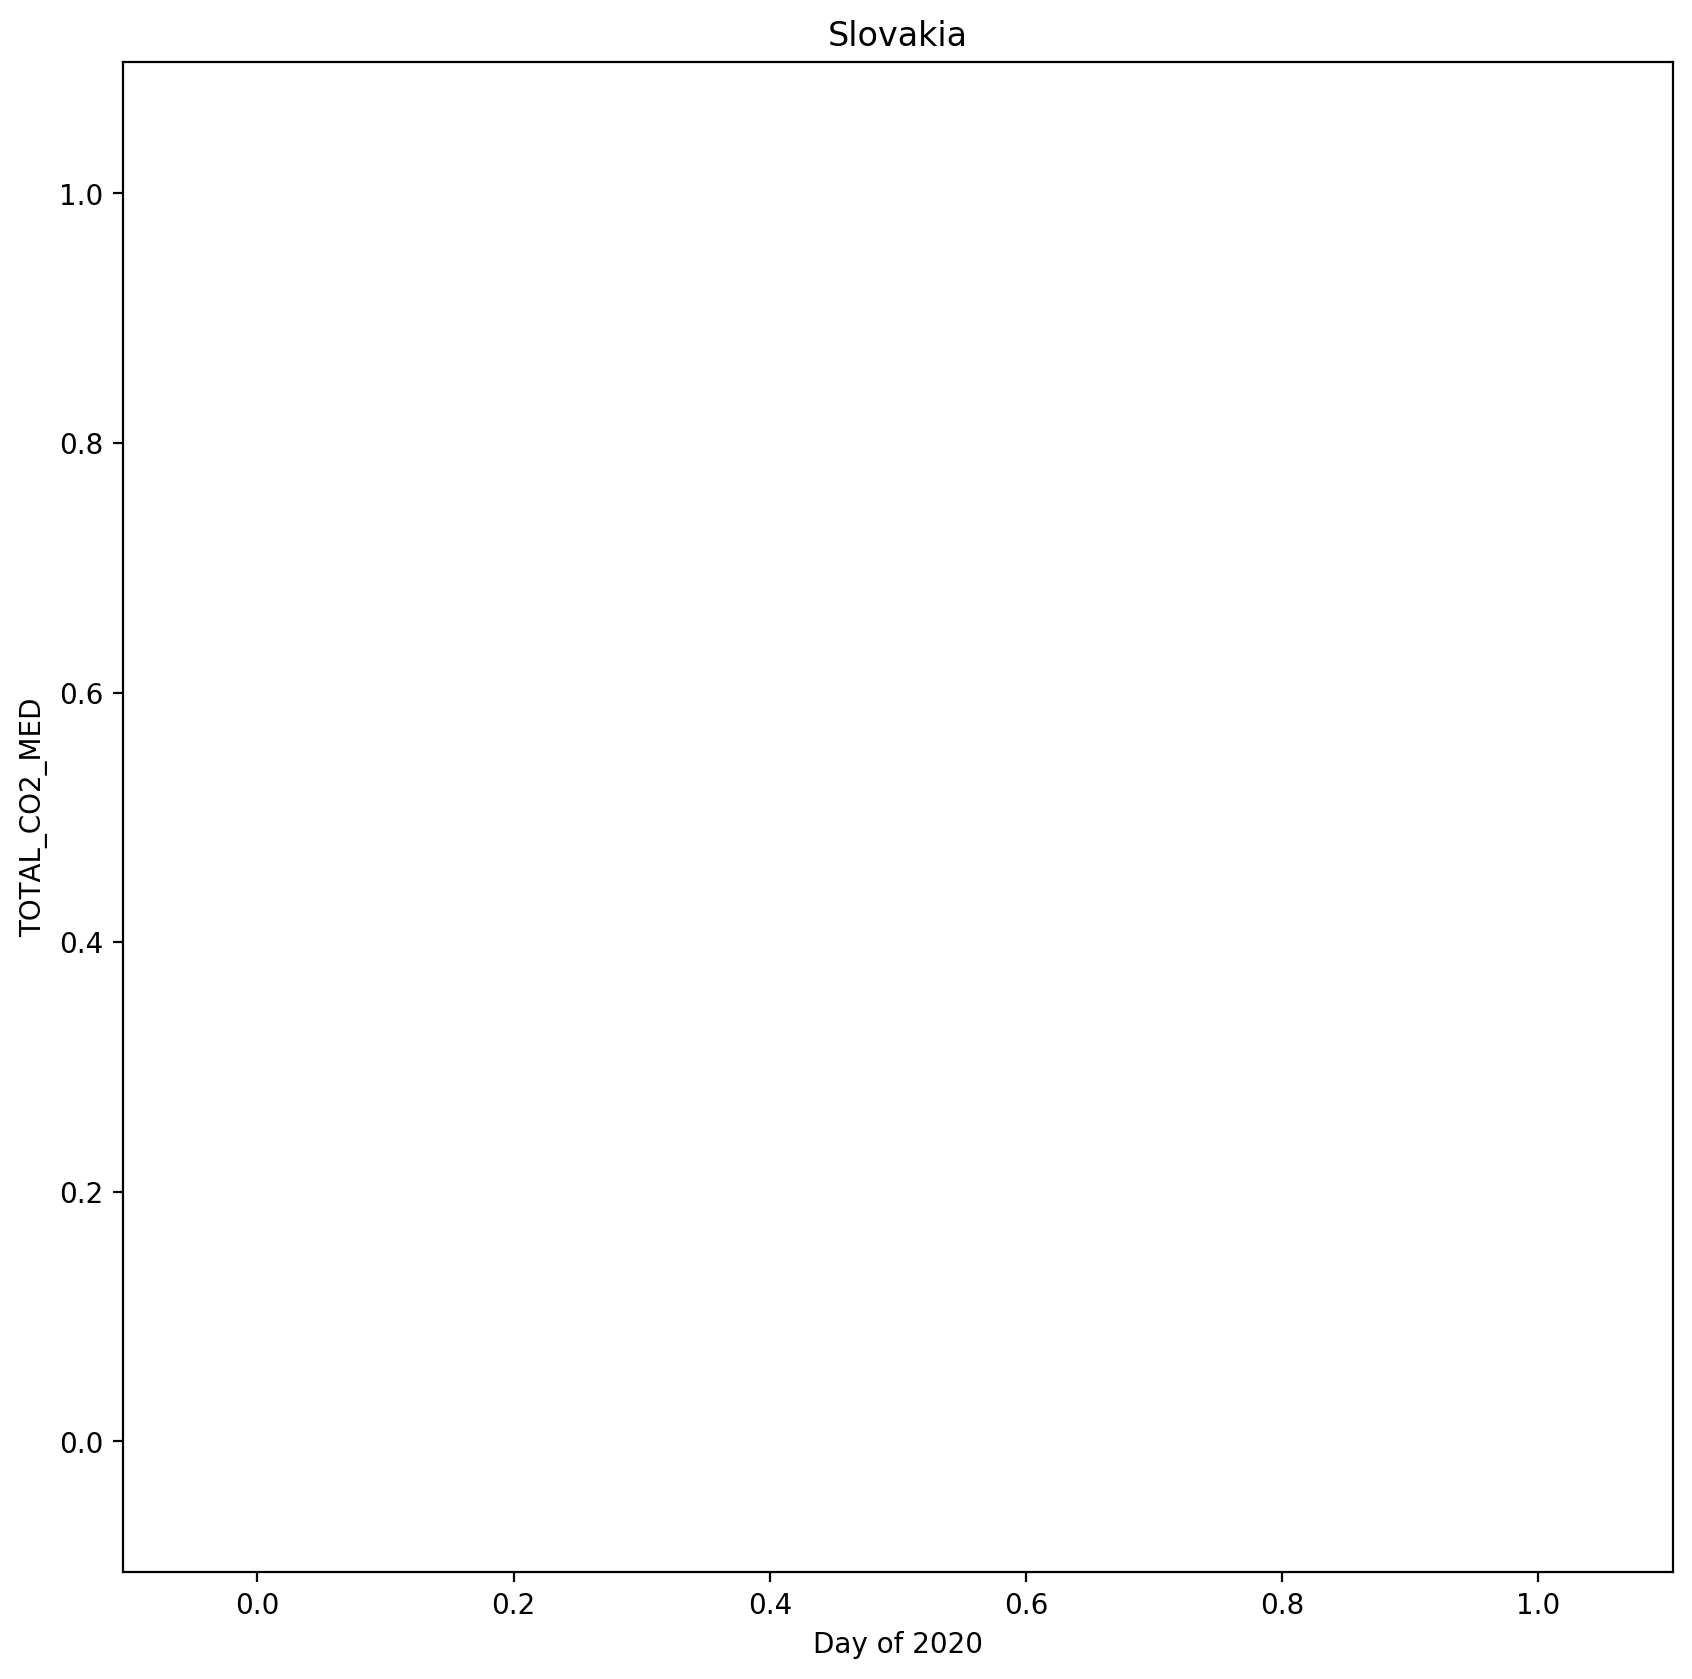

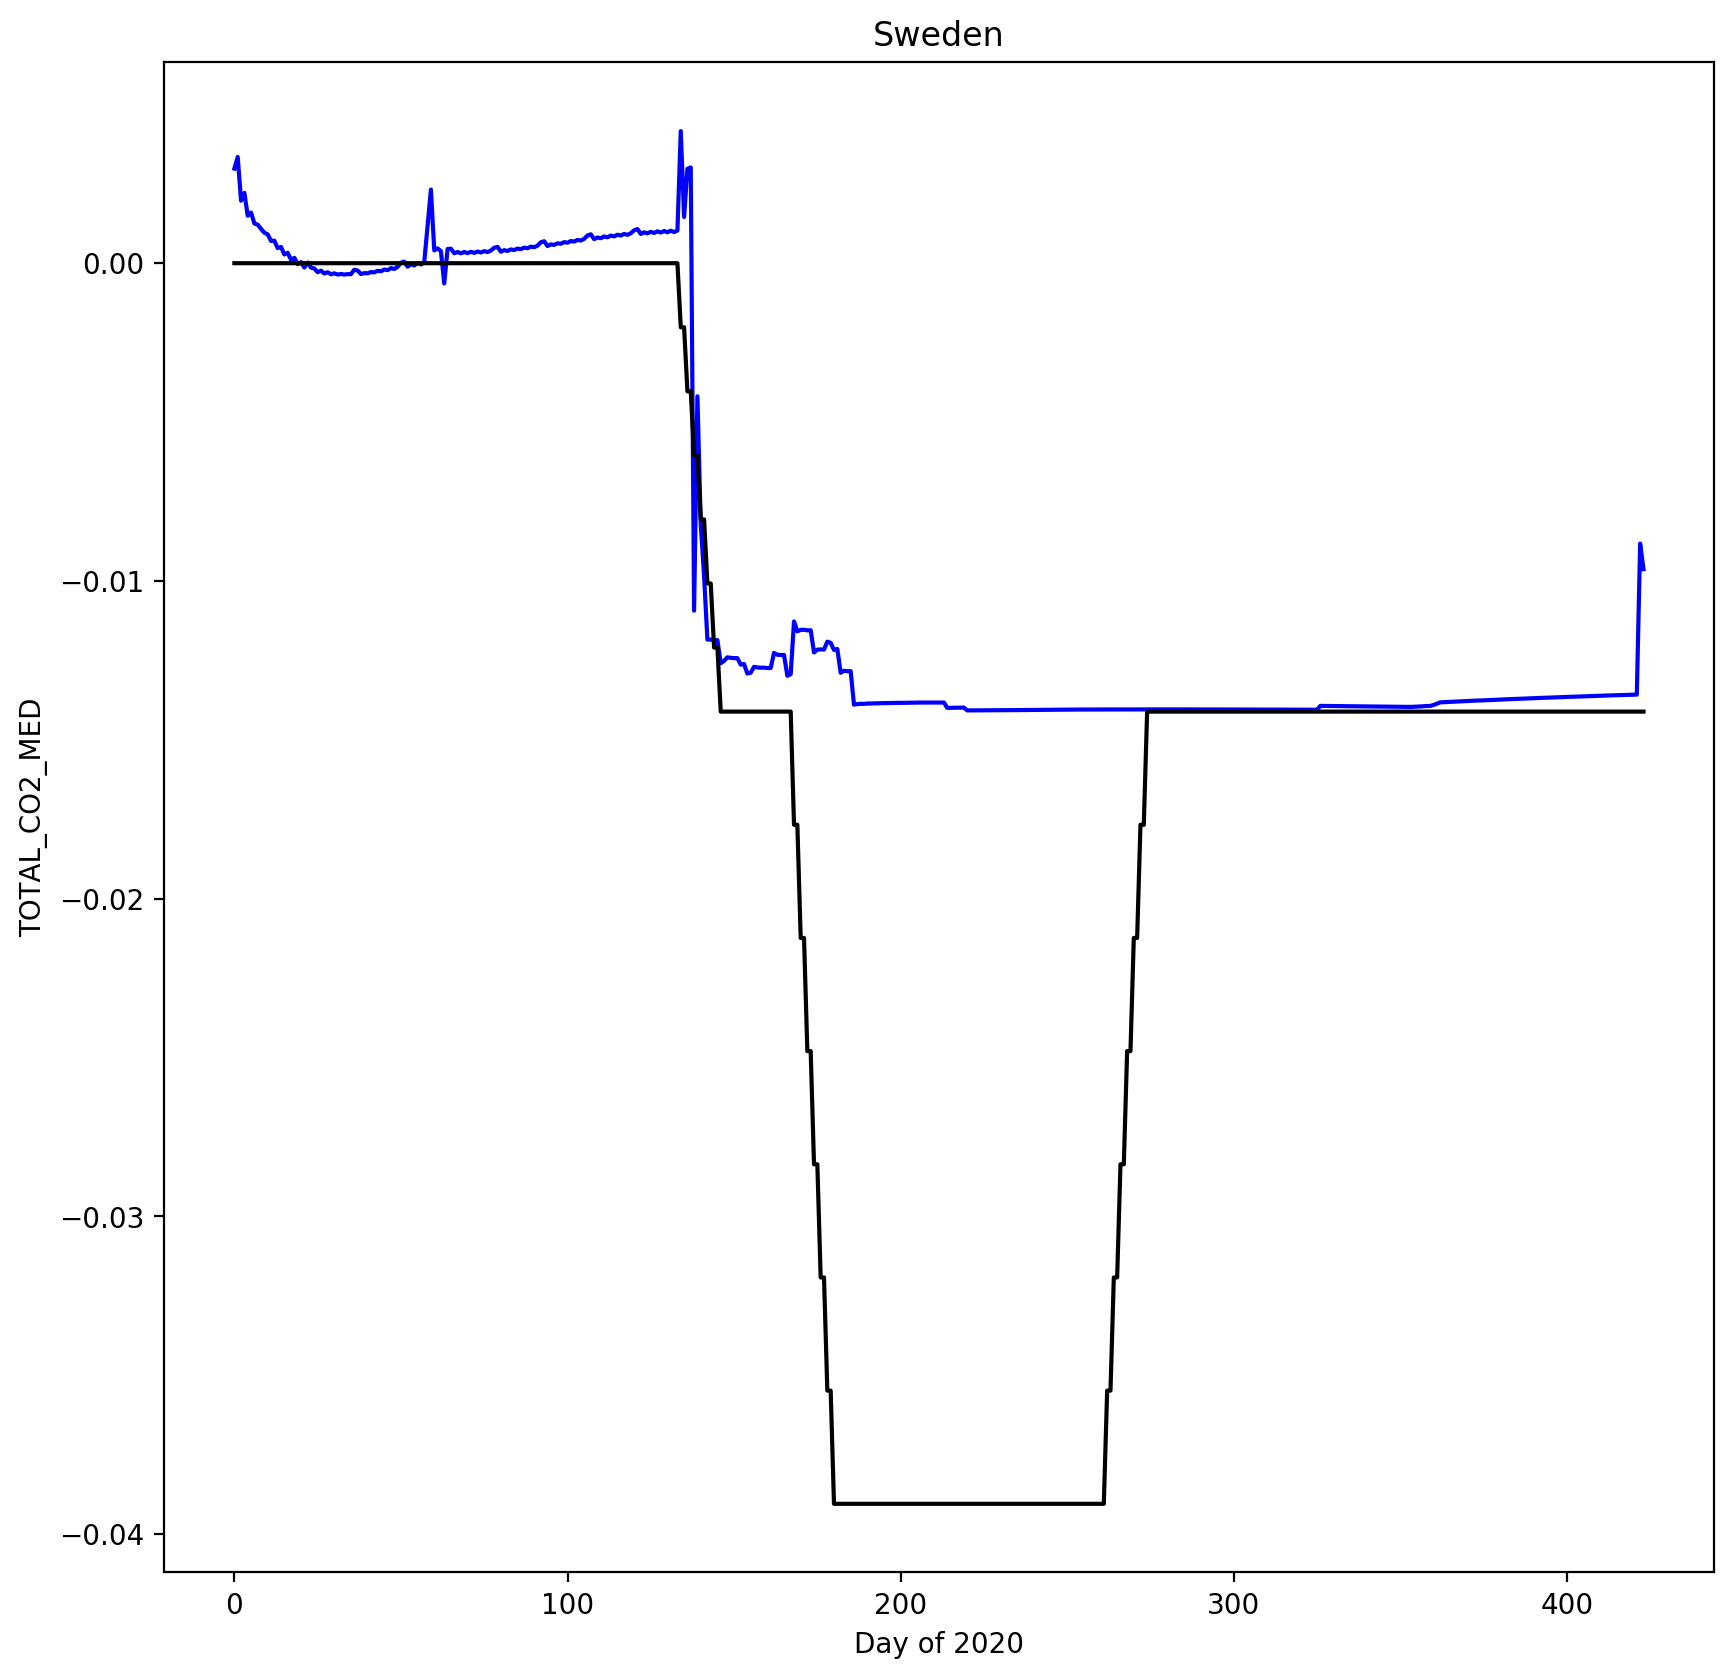

In [15]:
#list of countries:
C_list = cases['Country'].unique()

#num of countries:
num_countries = len(cases['Country'].unique())

#do a Test/train split:
lim = int(num_countries * 0.7)


###########################################
### PARAMS ################################r= 0.001 | n_steps= 4 | hidden size= 25 | epochs= 50
###########################################
NumberOfSteps = [3]#[3,4,7,9,14]
LearningRates = [0.001]#[0.001, 0.0015, 0.002, 0.00075]
LSTMSizes = [25]#[25, 50, 100, 200] 
Epochs = [100]#[50, 120, 200]
Plot = True
BatchSizes=[1]

FEATURES = [*range(5,27),31,*range(60,93),106,109,110,114]#[2,10,36, 21, 37,35,29,15]
n_features = len(FEATURES)

PREDICTION = 119#96 #or 101 ??
############################################
# Testing Loss
mse = tf.keras.losses.MeanSquaredError()


#############################################
### Loop de Loops beginns ###################
#############################################

country = cases[cases['Country']=='Germany']
print('Using the foloowing Features to learn:')
for i in FEATURES:
    print(country.columns[i])

low_loss = 999999999

for lr in LearningRates:
    for BS in BatchSizes:
        for n_steps in NumberOfSteps:
            for LSTM_hidden_size in LSTMSizes:
                for train_epochs in Epochs:


                    # define model
                    model = Sequential()
                    model.add(LSTM(LSTM_hidden_size, activation='relu', input_shape=(n_steps, n_features)))
                    model.add(Dense(1))
                    opt = keras.optimizers.Adam(learning_rate=lr)
                    cosine_loss = tf.keras.losses.CosineSimilarity(axis=0)
                    #model.compile(optimizer='adam', loss='mse') #default LR = 0.001
                    model.compile(optimizer=opt, loss='mse')

                    print('**Training started with following params: lr=',lr,'| n_steps=',n_steps,'| hidden size=',LSTM_hidden_size,'| epochs=', train_epochs)
                    start = time.time()
                    for c in C_list[0:lim]:
                        country = cases[cases['Country']==c]
                        print('Training on: ', c)
                        # define input sequence
                        in_seq = {}
                        dataset = []

                        for idx, i in enumerate(FEATURES):
                            #print(i, country.columns[i])
                            in_seq[idx] = np.asarray(country.values[:, [i]])
                            in_seq[idx] = in_seq[idx].reshape((len(in_seq[idx]), 1))


                        dataset = hstack((in_seq[0], in_seq[1]))

                        for o in range(2,len(in_seq)):
                            dataset = hstack((dataset, in_seq[o]))

                        out_seq = np.asarray(country.values[:, [PREDICTION]])
                        dataset = hstack((dataset, out_seq))
                        #dataset = hstack((in_seq1, in_seq2, in_seq3))




                        # convert into input/output
                        X, y = split_sequences(dataset, n_steps)


                        X = tf.convert_to_tensor(X, tf.int32)
                        # the dataset knows the number of features, e.g. 2
                        n_features = X.shape[2]
                        #print(n_features)
                        model.reset_states()
                        history = model.fit(X, y, batch_size=BS, epochs=train_epochs, verbose=0)

                        if Plot:
                            plt.figure(1)  

                             # summarize history for accuracy  

                            print(history.history.keys())  

                            plt.plot(history.history['loss'])  
                            plt.title('model loss')  
                            plt.ylabel('loss')  
                            plt.xlabel('epoch')  
                            plt.legend(['train'], loc='upper left')  
                            plt.show()  



                    end = time.time()
                    print('**Training Completed, elapsed time:',end - start,'**')
                    print('**Testing Started**')
                    a_err = [];


                    for c in C_list[lim:]:
                        country = cases[cases['Country']==c]
                        print('Testing on: ', c)
                        # define input sequence
                        in_seq = {}
                        dataset = []
                        res = []
                        for idx, i in enumerate(FEATURES):
                            #print(i, country.columns[i])
                            in_seq[idx] = np.asarray(country.values[:, [i]])
                            in_seq[idx] = in_seq[idx].reshape((len(in_seq[idx]), 1))


                        dataset = hstack((in_seq[0], in_seq[1]))

                        for o in range(2,len(in_seq)):
                            dataset = hstack((dataset, in_seq[o]))

                        out_seq = np.asarray(country.values[:, [PREDICTION]])
                        dataset = hstack((dataset, out_seq))
                        #dataset = hstack((in_seq1, in_seq2, in_seq3))




                        # convert into input/output
                        X, y = split_sequences(dataset, n_steps)

                        #print(len(X))

                        for i in range(len(X)):
                            x_input = X[i].astype(np.float32)
                            x_input = x_input.reshape((1, n_steps, n_features))
                            yhat = model.predict(x_input, verbose=0)
                            #print(yhat[0])
                            res.append(yhat[0][0])



                        y = np.asarray(y).astype(np.float32)
                        res = np.asarray(res).astype(np.float32)


                        a_err.append(mse(y, res).numpy())

                        if Plot:

                            plt.figure(num=None, figsize=(10, 10), dpi=200, facecolor='w', edgecolor='k')
                            plt.plot(res,'b')
                            plt.plot(y,'k')
                            plt.title(c)
                            plt.ylabel(country.columns[PREDICTION])
                            plt.xlabel('Day of 2020')

                            plt.show

                    a_err = np.asarray(a_err)
                    a_err = np.mean(a_err[~np.isnan(a_err)])

                    if a_err < low_loss:
                        print('NEW BEST!!!')
                        low_loss = a_err

                    print('**Testing Completed**')
                    print('**Average Error:', a_err)




<a class="anchor" id="diy"></a>
<h1>Prediction for non existent country</h1>

* In the end we ant to do predictions for non-existent countries
* This technically works already, but you need to construct a looooooong feature vector
* Expect this to work in the next release!

In [7]:




res = []
res2 = []

country = cases[cases['Country']=='Germany']
y = np.asarray(country.values[:, [41]])
for i in range(0,210):
    x_input = array([[i,   1, 1, 1, 1, 1, 1, 1, 1, 80.33], 
                     [i+1, 1, 1, 1, 1, 1, 1, 1, 1, 80.33], 
                     [i+2, 1, 1, 1, 1, 1, 1, 1, 1, 80.33],
                     [i+3, 1, 1, 1, 1, 1, 1, 1, 1, 80.33]])
    x_input = x_input.reshape((1, n_steps, n_features))
    yhat = model.predict(x_input, verbose=0)
    #print(yhat[0])
    res.append(max(yhat[0][0],0))
    
for i in range(0,210):
    x_input = array([[i,   0, 0, 0, 0, 0, 0, 0, 0, 80.33], 
                     [i+1, 0, 0, 0, 0, 0, 0, 0, 0, 80.33], 
                     [i+2, 0, 0, 0, 0, 0, 0, 0, 0, 80.33],
                     [i+3, 0, 0, 0, 0, 0, 0, 0, 0, 80.33]])
    x_input = x_input.reshape((1, n_steps, n_features))
    yhat = model.predict(x_input, verbose=0)
    #print(yhat[0])
    res2.append(max(yhat[0][0],0))
    
import matplotlib.pyplot as plt
plt.figure(num=None, figsize=(10, 10), dpi=400, facecolor='w', edgecolor='k')

plt.plot(res,'b')
plt.plot(res2,'r')
plt.plot(y,'k')

ValueError: cannot reshape array of size 40 into shape (1,4,60)